In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

def load_data(file_path):
    """
    Load the BigQuery results from a CSV file
    """
    # Adjust the column names based on your actual BigQuery results
    df = pd.read_csv(file_path)
    
    # Ensure date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values('date')
    
    return df

def preprocess_data(df, openai_launch_date):
    """
    Preprocess the data for analysis
    """
    # Calculate 7-day moving average to handle day-of-week effects
    df['new_repos_ma7'] = df['new_repos'].rolling(window=7, center=True).mean()
    
    # Calculate 30-day moving average for longer-term trends
    df['new_repos_ma30'] = df['new_repos'].rolling(window=30, center=True).mean()
    
    # Create a column to mark pre/post OpenAI launch
    df['post_openai'] = (df['date'] >= openai_launch_date).astype(int)
    
    # Create a time index for regression analysis
    df['time_index'] = range(len(df))
    df['time_since_openai'] = df['time_index'] * df['post_openai']
    
    return df

def plot_trends(df, openai_launch_date, save_path=None):
    """
    Plot the repository creation trends with OpenAI launch marked
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot raw data and moving averages
    axes[0].plot(df['date'], df['new_repos'], alpha=0.3, label='Daily New Repositories', color='gray')
    axes[0].plot(df['date'], df['new_repos_ma7'], label='7-day Moving Average', linewidth=2, color='blue')
    axes[0].plot(df['date'], df['new_repos_ma30'], label='30-day Moving Average', linewidth=2, color='darkgreen')
    
    # Mark OpenAI launch
    launch_date = pd.to_datetime(openai_launch_date)
    axes[0].axvline(x=launch_date, color='red', linestyle='--', label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add other significant AI releases if relevant
    # axes[0].axvline(x=pd.to_datetime('2023-03-14'), color='purple', linestyle='--', 
    #                label='GPT-4 Release (2023-03-14)')
    
    # Set title and labels
    axes[0].set_title('GitHub Repository Creation Over Time', fontsize=16)
    axes[0].set_ylabel('Number of New Repositories', fontsize=14)
    axes[0].legend(loc='upper left')
    
    # Format x-axis dates
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot percent change from previous year (YoY growth)
    # This helps identify if there's unusual growth beyond the normal yearly pattern
    df_with_yoy = calculate_yoy_growth(df)
    if 'yoy_growth' in df_with_yoy.columns:
        mask = ~df_with_yoy['yoy_growth'].isna()
        axes[1].plot(df_with_yoy.loc[mask, 'date'], 
                    df_with_yoy.loc[mask, 'yoy_growth'], 
                    label='YoY Growth %', color='orange', linewidth=2)
        axes[1].axvline(x=launch_date, color='red', linestyle='--')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].set_ylabel('YoY Growth %', fontsize=14)
        axes[1].legend(loc='upper left')
        
        # Format x-axis dates (same as the main plot)
        axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def calculate_yoy_growth(df):
    """
    Calculate year-over-year growth percentages
    """
    try:
        # Create a copy to avoid modifying the original dataframe
        df_yoy = df.copy()
        
        # Get values from exactly one year ago
        df_yoy['prev_year_value'] = df_yoy['new_repos_ma30'].shift(365)
        
        # Calculate YoY growth percentage
        df_yoy['yoy_growth'] = ((df_yoy['new_repos_ma30'] / df_yoy['prev_year_value']) - 1) * 100
        
        return df_yoy
    except Exception as e:
        print(f"Could not calculate YoY growth: {e}")
        return df

def perform_statistical_analysis(df, openai_launch_date):
    """
    Perform statistical analysis to quantify changes before and after OpenAI launch
    """
    # Filter to ensure we have equal time periods before and after launch for fair comparison
    launch_idx = df[df['date'] >= openai_launch_date].index[0]
    days_after_launch = len(df) - launch_idx
    days_to_use = min(launch_idx, days_after_launch)
    
    # Get equal periods before and after
    before_df = df.iloc[launch_idx - days_to_use:launch_idx]
    after_df = df.iloc[launch_idx:launch_idx + days_to_use]
    
    # Basic statistics
    before_mean = before_df['new_repos'].mean()
    after_mean = after_df['new_repos'].mean()
    percent_change = ((after_mean / before_mean) - 1) * 100
    
    print("\n===== Statistical Analysis =====")
    print(f"Time periods analyzed: {days_to_use} days before and after OpenAI launch")
    print(f"Average daily new repositories before launch: {before_mean:.2f}")
    print(f"Average daily new repositories after launch: {after_mean:.2f}")
    print(f"Percent change: {percent_change:.2f}%")
    
    # Test statistical significance (t-test)
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(before_df['new_repos'], after_df['new_repos'], equal_var=False)
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"The change is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at the 5% level")
    
    # Interrupted Time Series Analysis
    print("\n===== Interrupted Time Series Analysis =====")
    try:
        # Prepare data for ITS analysis
        analysis_df = df.copy()
        analysis_df['time'] = range(len(analysis_df))
        analysis_df['intervention'] = (analysis_df['date'] >= openai_launch_date).astype(int)
        analysis_df['time_after'] = analysis_df['time'] * analysis_df['intervention']
        
        # Fit the model
        model = smf.ols('new_repos ~ time + intervention + time_after', data=analysis_df).fit()
        print(model.summary().tables[1])
        
        # Interpret the key coefficients
        print("\nInterpretation:")
        if model.params['intervention'] > 0 and model.pvalues['intervention'] < 0.05:
            print(f"There was an immediate INCREASE of {model.params['intervention']:.2f} repositories after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
        elif model.params['intervention'] < 0 and model.pvalues['intervention'] < 0.05:
            print(f"There was an immediate DECREASE of {-model.params['intervention']:.2f} repositories after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
        else:
            print(f"No significant immediate change after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
            
        if model.params['time_after'] > 0 and model.pvalues['time_after'] < 0.05:
            print(f"The SLOPE of repository creation INCREASED by {model.params['time_after']:.4f} per day after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
        elif model.params['time_after'] < 0 and model.pvalues['time_after'] < 0.05:
            print(f"The SLOPE of repository creation DECREASED by {-model.params['time_after']:.4f} per day after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
        else:
            print(f"No significant change in the trend after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
            
    except Exception as e:
        print(f"Could not perform interrupted time series analysis: {e}")

def decompose_time_series(df):
    """
    Decompose the time series into trend, seasonal, and residual components
    """
    try:
        # Ensure we have no missing values
        df_decomp = df.copy()
        df_decomp = df_decomp.dropna(subset=['new_repos'])
        
        # Set date as index for decomposition
        df_decomp = df_decomp.set_index('date')
        
        # Perform decomposition (adjust period based on your data - e.g., 7 for weekly patterns)
        decomposition = seasonal_decompose(df_decomp['new_repos'], model='additive', period=7)
        
        # Plot the decomposition
        fig, axes = plt.subplots(4, 1, figsize=(14, 16))
        
        decomposition.observed.plot(ax=axes[0])
        axes[0].set_title('Observed', fontsize=14)
        
        decomposition.trend.plot(ax=axes[1])
        axes[1].set_title('Trend', fontsize=14)
        
        decomposition.seasonal.plot(ax=axes[2])
        axes[2].set_title('Seasonal', fontsize=14)
        
        decomposition.resid.plot(ax=axes[3])
        axes[3].set_title('Residual', fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        return decomposition
        
    except Exception as e:
        print(f"Could not perform time series decomposition: {e}")
        return None

Loaded data with 2183 rows from 2019-01-01 00:00:00 to 2024-12-31 00:00:00


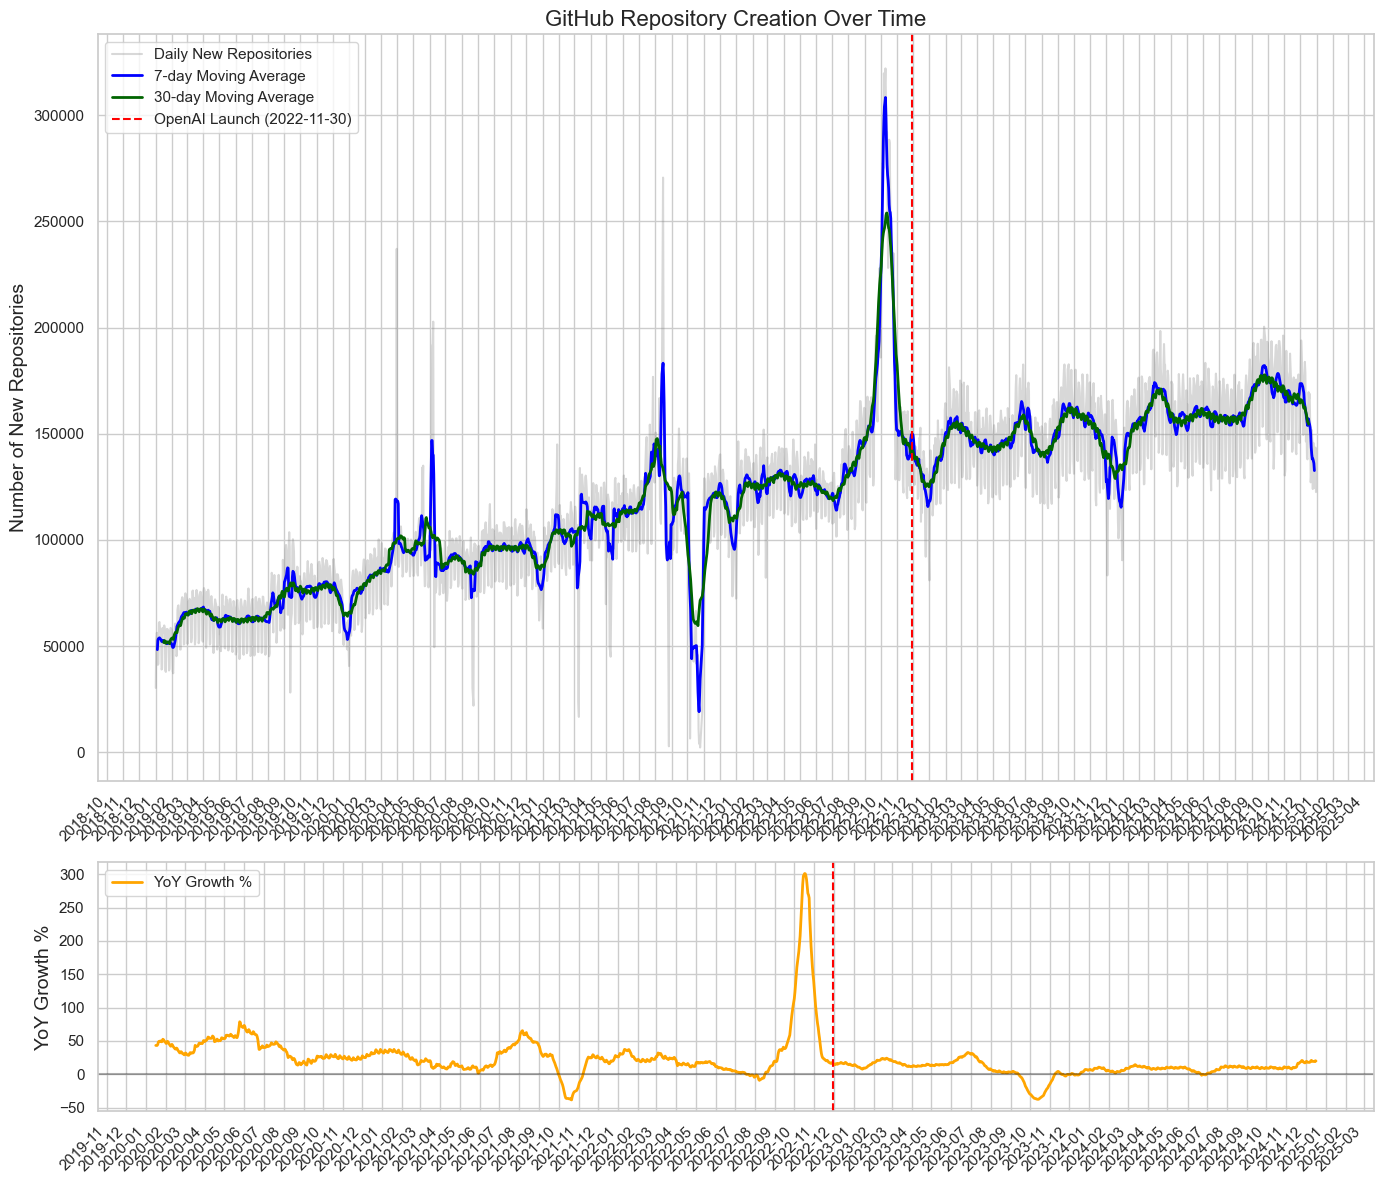


===== Statistical Analysis =====
Time periods analyzed: 763 days before and after OpenAI launch
Average daily new repositories before launch: 122608.02
Average daily new repositories after launch: 153400.44
Percent change: 25.11%
t-statistic: -19.3432
p-value: 0.0000
The change is statistically significant at the 5% level

===== Interrupted Time Series Analysis =====
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.283e+04   1292.119     40.887      0.000    5.03e+04    5.54e+04
time            68.9207      1.577     43.706      0.000      65.828      72.013
intervention  3.594e+04   7378.223      4.871      0.000    2.15e+04    5.04e+04
time_after     -33.0337      4.303     -7.677      0.000     -41.472     -24.595

Interpretation:
There was an immediate INCREASE of 35936.51 repositories after the OpenAI launch (p=0.0000)
The SLOPE of repository creation D

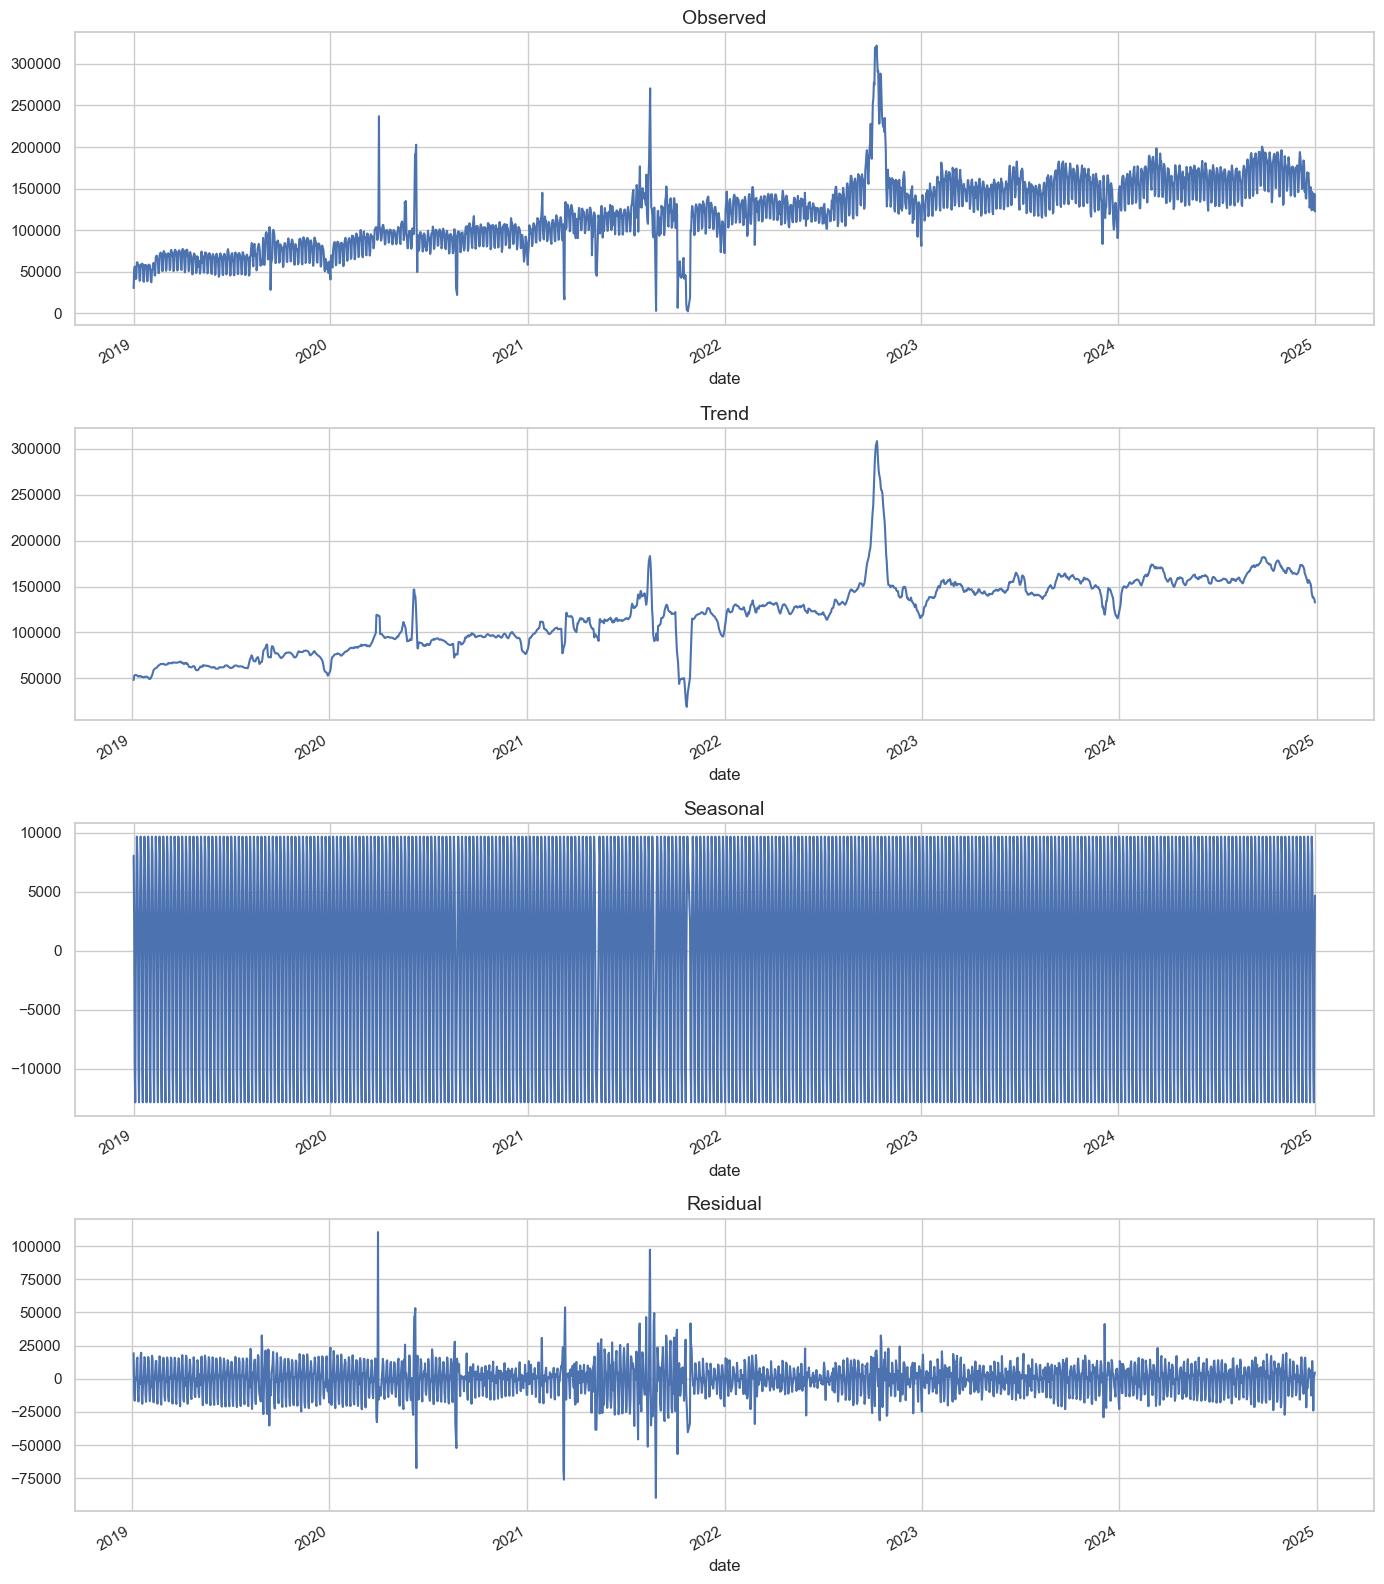

In [10]:
file_path = "bq-results-3.csv"  # Update this to your actual file path
openai_launch_date = "2022-11-30"
df = load_data(file_path)
print(f"Loaded data with {len(df)} rows from {df['date'].min()} to {df['date'].max()}")
df = preprocess_data(df, openai_launch_date)
plot_trends(df, openai_launch_date, save_path="github_repo_trends.png")
perform_statistical_analysis(df, openai_launch_date)
decomposition = decompose_time_series(df)

Loading data...
Data loaded: 2183 days from 2019-01-01 00:00:00 to 2024-12-31 00:00:00
Splitting data at OpenAI launch date: 2022-11-30
Pre-launch period: 1420 days
Post-launch period: 763 days
Fitting SARIMA model...
Model fitting complete
Generating forecast for 763 days after launch...

===== Impact Metrics =====
Total actual repositories: 117,044,539
Total predicted repositories: -2,740,036.095892284
Total difference: 119,784,575.09589228 repositories
Total percentage difference: -4371.64%
Average daily difference: 156991.58 repositories
Average daily percentage difference: -178.63%
Days outside 95% confidence interval: 0 (0.00%)

Analysis complete! Results saved to CSV files.


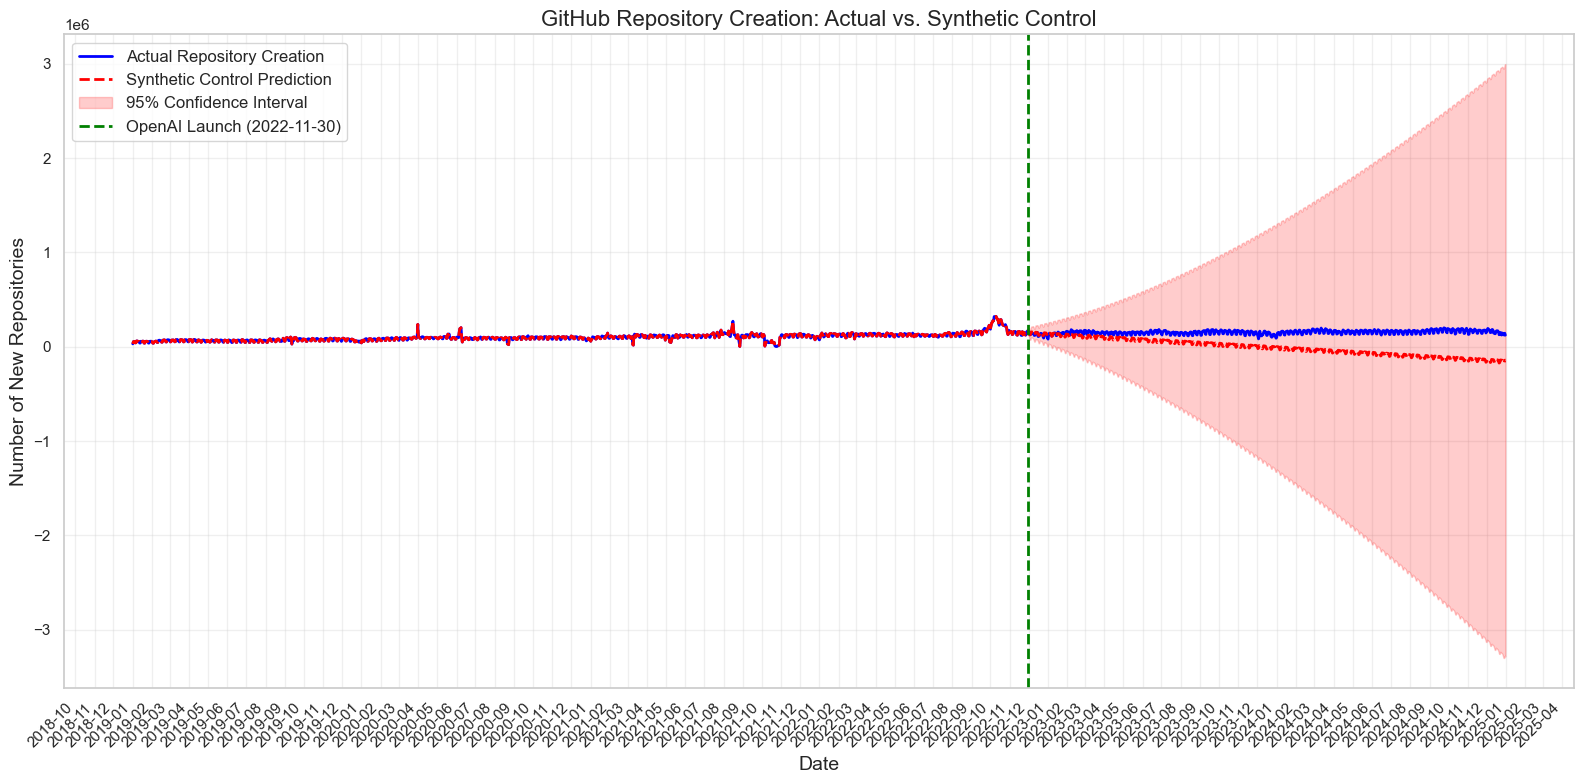

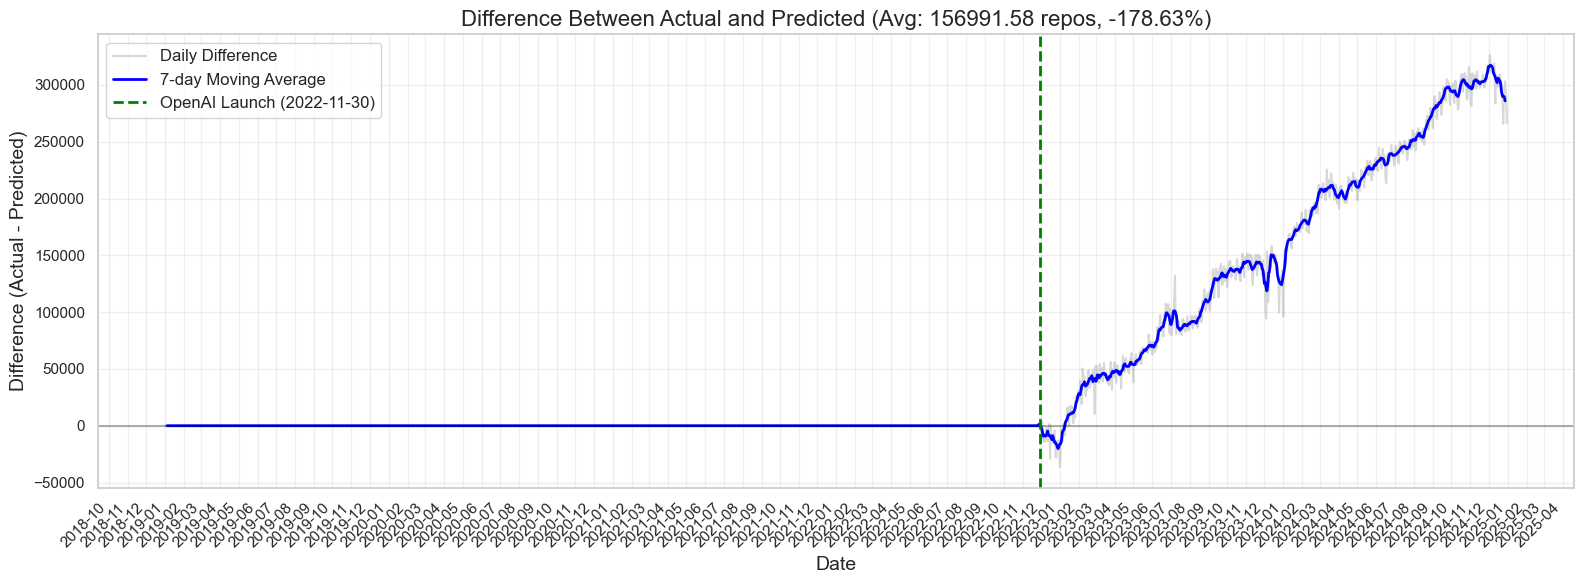

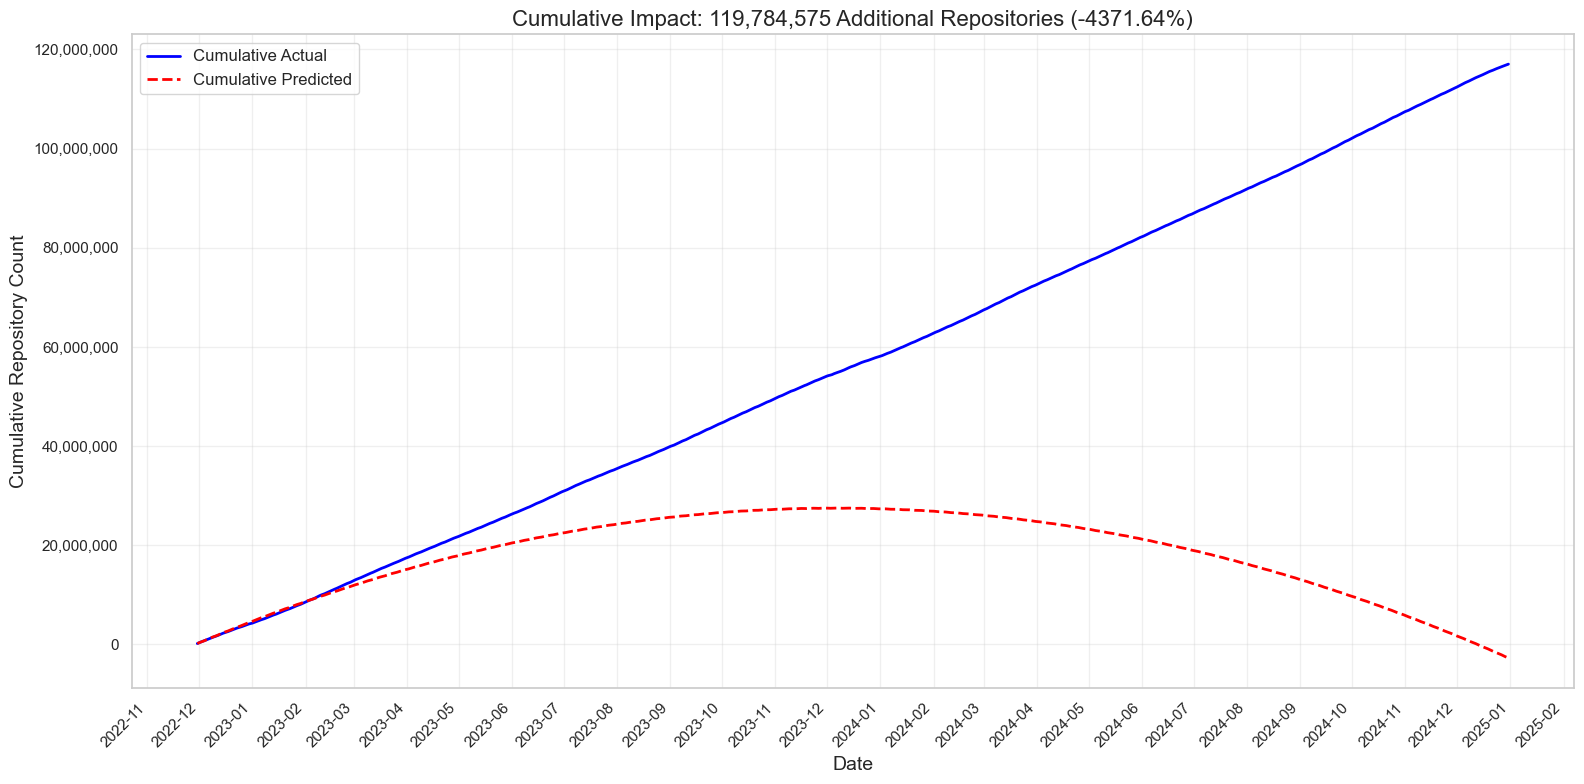

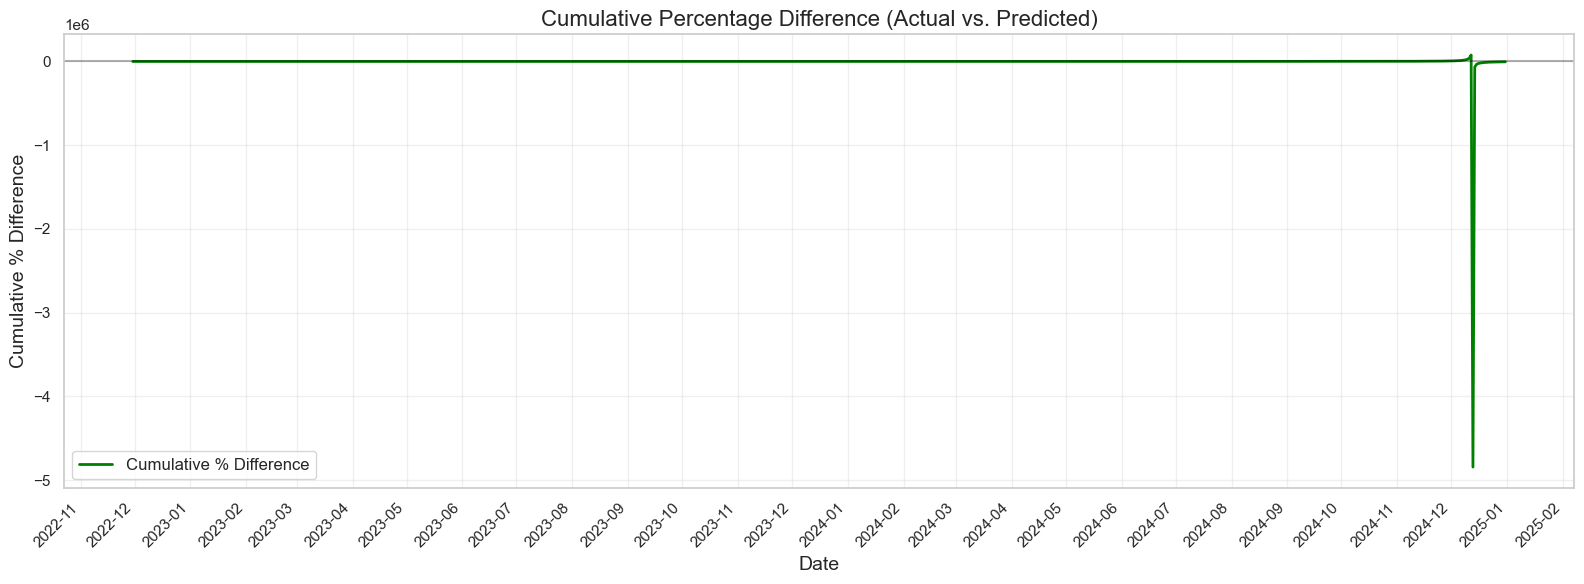

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Define the OpenAI launch date (ChatGPT public release)
openai_launch_date = "2022-11-30"

# Load data
def load_data(file_path):
    """
    Load the GitHub repository data from CSV
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    return df

# Create a function to split data into pre and post launch periods
def split_data(df, launch_date):
    """
    Split the data into pre and post launch periods
    """
    df['post_launch'] = (df['date'] >= launch_date).astype(int)
    pre_launch = df[df['date'] < launch_date]
    post_launch = df[df['date'] >= launch_date]
    return pre_launch, post_launch

# Build a SARIMA model for forecasting
def build_sarima_model(pre_launch_df):
    """
    Build and train a SARIMA model on pre-launch data
    """
    # Set date as index for time series modeling
    ts_data = pre_launch_df.set_index('date')['new_repos']
    
    # Determine model parameters (use auto_arima or set manually)
    # For this example, we'll use parameters that typically work well with daily data
    # p,d,q for ARIMA and P,D,Q,s for seasonal component
    # For daily data with weekly seasonality, s=7 is common
    p, d, q = 1, 1, 1
    P, D, Q, s = 1, 1, 1, 7
    
    # Build the model
    model = SARIMAX(
        ts_data,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Fit the model
    print("Fitting SARIMA model...")
    model_fit = model.fit(disp=False)
    print("Model fitting complete")
    
    return model_fit

# Generate counterfactual predictions
def generate_counterfactual(model_fit, full_df, pre_launch_df, post_launch_df):
    """
    Generate counterfactual predictions for the post-launch period
    """
    # Number of steps to forecast
    steps = len(post_launch_df)
    
    # Create forecast
    print(f"Generating forecast for {steps} days after launch...")
    forecast = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    
    # Get confidence intervals
    confidence_intervals = forecast.conf_int()
    lower_bound = confidence_intervals.iloc[:, 0]
    upper_bound = confidence_intervals.iloc[:, 1]
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'date': post_launch_df['date'].values,
        'predicted_repos': forecast_mean.values,
        'lower_ci': lower_bound.values,
        'upper_ci': upper_bound.values,
        'actual_repos': post_launch_df['new_repos'].values
    })
    
    # Calculate difference between actual and predicted
    forecast_df['diff'] = forecast_df['actual_repos'] - forecast_df['predicted_repos']
    forecast_df['percent_diff'] = (forecast_df['diff'] / forecast_df['predicted_repos']) * 100
    
    # Combine with the pre-launch data for plotting
    pre_forecast_df = pd.DataFrame({
        'date': pre_launch_df['date'].values,
        'predicted_repos': pre_launch_df['new_repos'].values,  # Use actual as predicted for pre-launch
        'lower_ci': pre_launch_df['new_repos'].values,
        'upper_ci': pre_launch_df['new_repos'].values,
        'actual_repos': pre_launch_df['new_repos'].values,
        'diff': np.zeros(len(pre_launch_df)),  # Zero difference for pre-launch period
        'percent_diff': np.zeros(len(pre_launch_df))  # Zero percent diff for pre-launch period
    })
    
    full_forecast_df = pd.concat([pre_forecast_df, forecast_df], ignore_index=True)
    full_forecast_df = full_forecast_df.sort_values('date')
    
    return full_forecast_df

# Calculate impact metrics
def calculate_impact(forecast_df, openai_launch_date):
    """
    Calculate the impact of OpenAI launch on repository creation
    """
    # Filter to post-launch period
    post_launch_forecast = forecast_df[forecast_df['date'] >= openai_launch_date]
    
    # Calculate differences between actual and predicted
    # These calculations are now handled in the generate_counterfactual function
    
    # Calculate cumulative impact
    total_actual = post_launch_forecast['actual_repos'].sum()
    total_predicted = post_launch_forecast['predicted_repos'].sum()
    total_diff = total_actual - total_predicted
    total_percent = (total_diff / total_predicted) * 100
    
    # Calculate average daily impact
    avg_diff = post_launch_forecast['diff'].mean()
    avg_percent = post_launch_forecast['percent_diff'].mean()
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos']))
    mae = mean_absolute_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos'])
    
    # Check if actual values are consistently outside the confidence interval
    outside_ci_count = sum(
        (post_launch_forecast['actual_repos'] > post_launch_forecast['upper_ci']) | 
        (post_launch_forecast['actual_repos'] < post_launch_forecast['lower_ci'])
    )
    outside_ci_percent = (outside_ci_count / len(post_launch_forecast)) * 100
    
    impact_metrics = {
        'total_actual': total_actual,
        'total_predicted': total_predicted,
        'total_diff': total_diff,
        'total_percent': total_percent,
        'avg_diff': avg_diff,
        'avg_percent': avg_percent,
        'rmse': rmse,
        'mae': mae,
        'outside_ci_count': outside_ci_count,
        'outside_ci_percent': outside_ci_percent
    }
    
    return impact_metrics, post_launch_forecast

# Plot the results
def plot_synthetic_control(forecast_df, openai_launch_date):
    """
    Plot the actual vs. counterfactual prediction
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot actual data
    ax.plot(forecast_df['date'], forecast_df['actual_repos'], 
            label='Actual Repository Creation', color='blue', linewidth=2)
    
    # Plot predicted data
    ax.plot(forecast_df['date'], forecast_df['predicted_repos'], 
            label='Synthetic Control Prediction', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals
    ax.fill_between(forecast_df['date'], 
                   forecast_df['lower_ci'], 
                   forecast_df['upper_ci'], 
                   color='red', alpha=0.2, label='95% Confidence Interval')
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    ax.set_title('GitHub Repository Creation: Actual vs. Synthetic Control', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Number of New Repositories', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot the difference between actual and predicted
def plot_difference(forecast_df, openai_launch_date, impact_metrics):
    """
    Plot the difference between actual and predicted values
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Calculate rolling average of difference to smooth out daily fluctuations
    forecast_df['diff_ma7'] = forecast_df['diff'].rolling(window=7, center=True).mean()
    
    # Plot the difference
    ax.plot(forecast_df['date'], forecast_df['diff'], color='gray', alpha=0.3, label='Daily Difference')
    ax.plot(forecast_df['date'], forecast_df['diff_ma7'], color='blue', linewidth=2, label='7-day Moving Average')
    
    # Add a zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    avg_diff = impact_metrics['avg_diff']
    avg_percent = impact_metrics['avg_percent']
    ax.set_title(f'Difference Between Actual and Predicted (Avg: {avg_diff:.2f} repos, {avg_percent:.2f}%)', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Difference (Actual - Predicted)', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot cumulative impact
def plot_cumulative_impact(forecast_df, openai_launch_date):
    """
    Plot the cumulative impact of OpenAI launch on repository creation
    """
    # Calculate cumulative values
    post_launch = forecast_df[forecast_df['date'] >= openai_launch_date].copy()
    post_launch['cum_actual'] = post_launch['actual_repos'].cumsum()
    post_launch['cum_predicted'] = post_launch['predicted_repos'].cumsum()
    post_launch['cum_diff'] = post_launch['cum_actual'] - post_launch['cum_predicted']
    post_launch['cum_percent'] = (post_launch['cum_diff'] / post_launch['cum_predicted']) * 100
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot cumulative actual and predicted
    ax.plot(post_launch['date'], post_launch['cum_actual'], 
            label='Cumulative Actual', color='blue', linewidth=2)
    ax.plot(post_launch['date'], post_launch['cum_predicted'], 
            label='Cumulative Predicted', color='red', linestyle='--', linewidth=2)
    
    # Add labels and title
    final_diff = post_launch['cum_diff'].iloc[-1]
    final_percent = post_launch['cum_percent'].iloc[-1]
    ax.set_title(f'Cumulative Impact: {final_diff:,.0f} Additional Repositories ({final_percent:.2f}%)', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Cumulative Repository Count', fontsize=14)
    
    # Format y-axis with commas for thousands
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Create a second plot for cumulative percentage difference
    fig2, ax2 = plt.subplots(figsize=(16, 6))
    
    ax2.plot(post_launch['date'], post_launch['cum_percent'], 
            label='Cumulative % Difference', color='green', linewidth=2)
    
    # Add a zero line
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    ax2.set_title('Cumulative Percentage Difference (Actual vs. Predicted)', fontsize=16)
    ax2.set_xlabel('Date', fontsize=14)
    ax2.set_ylabel('Cumulative % Difference', fontsize=14)
    
    # Format x-axis dates
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax2.legend(loc='best', fontsize=12)
    
    # Add grid
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, fig2, post_launch

# Main function to run the synthetic control analysis
def run_synthetic_control_analysis(file_path):
    """
    Run the synthetic control analysis on GitHub repository data
    """
    print("Loading data...")
    df = load_data(file_path)
    print(f"Data loaded: {len(df)} days from {df['date'].min()} to {df['date'].max()}")
    
    # Check if the required columns exist
    required_columns = ['date', 'new_repos']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the data")
            # Check if there are similar column names that might be used instead
            similar_cols = [c for c in df.columns if col.lower() in c.lower()]
            if similar_cols:
                print(f"Found similar columns: {similar_cols}")
                # If we find a likely match for 'new_repos', use it
                if col == 'new_repos' and len(similar_cols) == 1:
                    print(f"Using '{similar_cols[0]}' as '{col}'")
                    df[col] = df[similar_cols[0]]
                else:
                    return None, None, None
            else:
                return None, None, None
    
    # Split data into pre and post launch periods
    print(f"Splitting data at OpenAI launch date: {openai_launch_date}")
    pre_launch, post_launch = split_data(df, openai_launch_date)
    print(f"Pre-launch period: {len(pre_launch)} days")
    print(f"Post-launch period: {len(post_launch)} days")
    
    # Build the SARIMA model on pre-launch data
    model_fit = build_sarima_model(pre_launch)
    
    # Generate counterfactual predictions
    forecast_df = generate_counterfactual(model_fit, df, pre_launch, post_launch)
    
    # Calculate impact metrics
    impact_metrics, post_forecast = calculate_impact(forecast_df, openai_launch_date)
    
    # Display impact metrics
    print("\n===== Impact Metrics =====")
    print(f"Total actual repositories: {impact_metrics['total_actual']:,}")
    print(f"Total predicted repositories: {impact_metrics['total_predicted']:,}")
    print(f"Total difference: {impact_metrics['total_diff']:,} repositories")
    print(f"Total percentage difference: {impact_metrics['total_percent']:.2f}%")
    print(f"Average daily difference: {impact_metrics['avg_diff']:.2f} repositories")
    print(f"Average daily percentage difference: {impact_metrics['avg_percent']:.2f}%")
    print(f"Days outside 95% confidence interval: {impact_metrics['outside_ci_count']} ({impact_metrics['outside_ci_percent']:.2f}%)")
    
    # Plot the results
    fig1 = plot_synthetic_control(forecast_df, openai_launch_date)
    fig2 = plot_difference(forecast_df, openai_launch_date, impact_metrics)
    fig3, fig4, cum_data = plot_cumulative_impact(forecast_df, openai_launch_date)
    
    # Save the results
    forecast_df.to_csv('synthetic_control_forecast.csv', index=False)
    cum_data.to_csv('cumulative_impact.csv', index=False)
    
    print("\nAnalysis complete! Results saved to CSV files.")
    
    return forecast_df, impact_metrics, (fig1, fig2, fig3, fig4)

# Run the analysis
if __name__ == "__main__":
    file_path = "bq-results-3.csv"  # Update this to your actual file path
    forecast_df, impact_metrics, figures = run_synthetic_control_analysis(file_path)

Loading data...
Data loaded: 2183 days from 2019-01-01 00:00:00 to 2024-12-31 00:00:00
Training data: 1136 days (2019-01-01 00:00:00 to 2022-02-18 00:00:00)
Validation data: 284 days (2022-02-19 00:00:00 to 2022-11-29 00:00:00)
Test data: 763 days (2022-11-30 00:00:00 to 2024-12-31 00:00:00)

Naive Forecast Performance Metrics:
RMSE: 57509.21
MAE: 38638.67
MAPE: 22.05%
R² Score: -0.7869

Moving Average (30-day) Performance Metrics:
RMSE: 47998.19
MAE: 28082.24
MAPE: 15.56%
R² Score: -0.2447

Simple Exponential Smoothing Performance Metrics:
RMSE: 56800.02
MAE: 37694.73
MAPE: 21.40%
R² Score: -0.7431

Holt-Winters Performance Metrics:
RMSE: 36984.23
MAE: 21681.98
MAPE: 12.79%
R² Score: 0.2610

SARIMA Performance Metrics:
RMSE: 43565.82
MAE: 22586.57
MAPE: 11.84%
R² Score: -0.0254

Best model based on RMSE: Holt-Winters (RMSE: 36984.23)
Building Holt-Winters on full pre-launch data...
Holt-Winters model built successfully
Generating forecast for 763 days after launch...

===== Impact Met

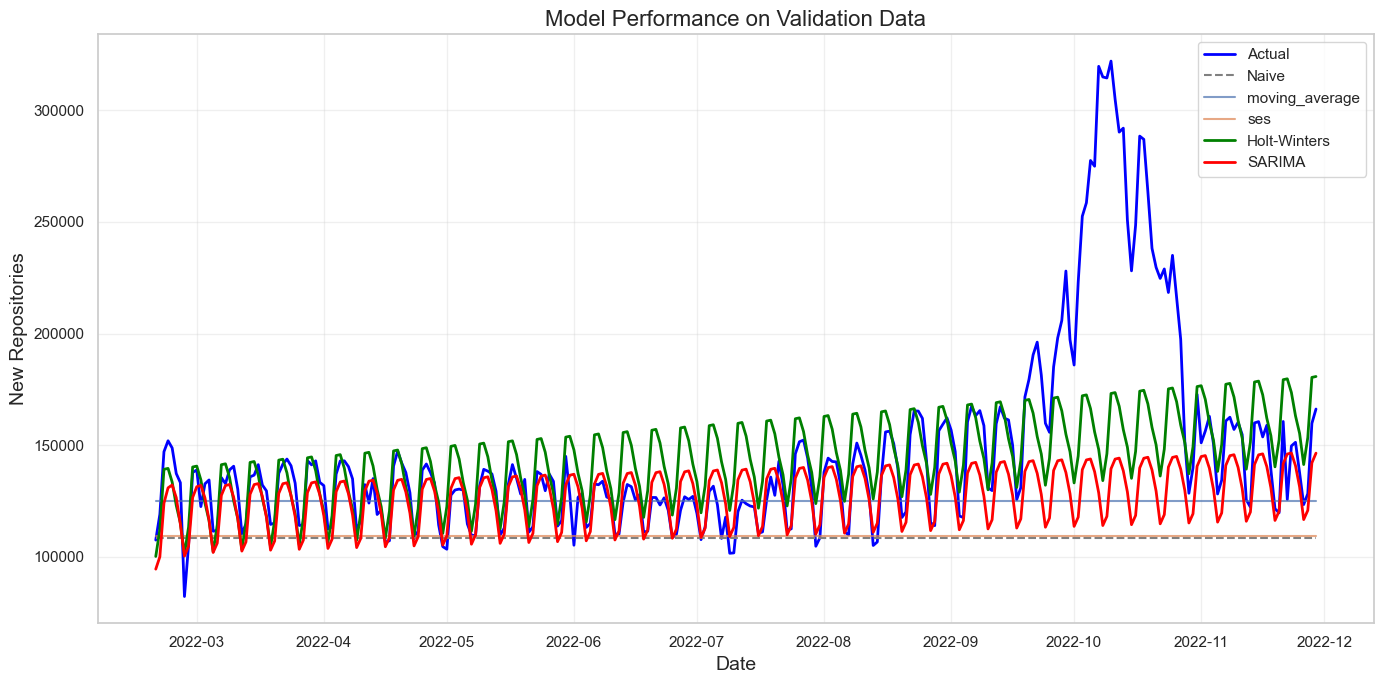

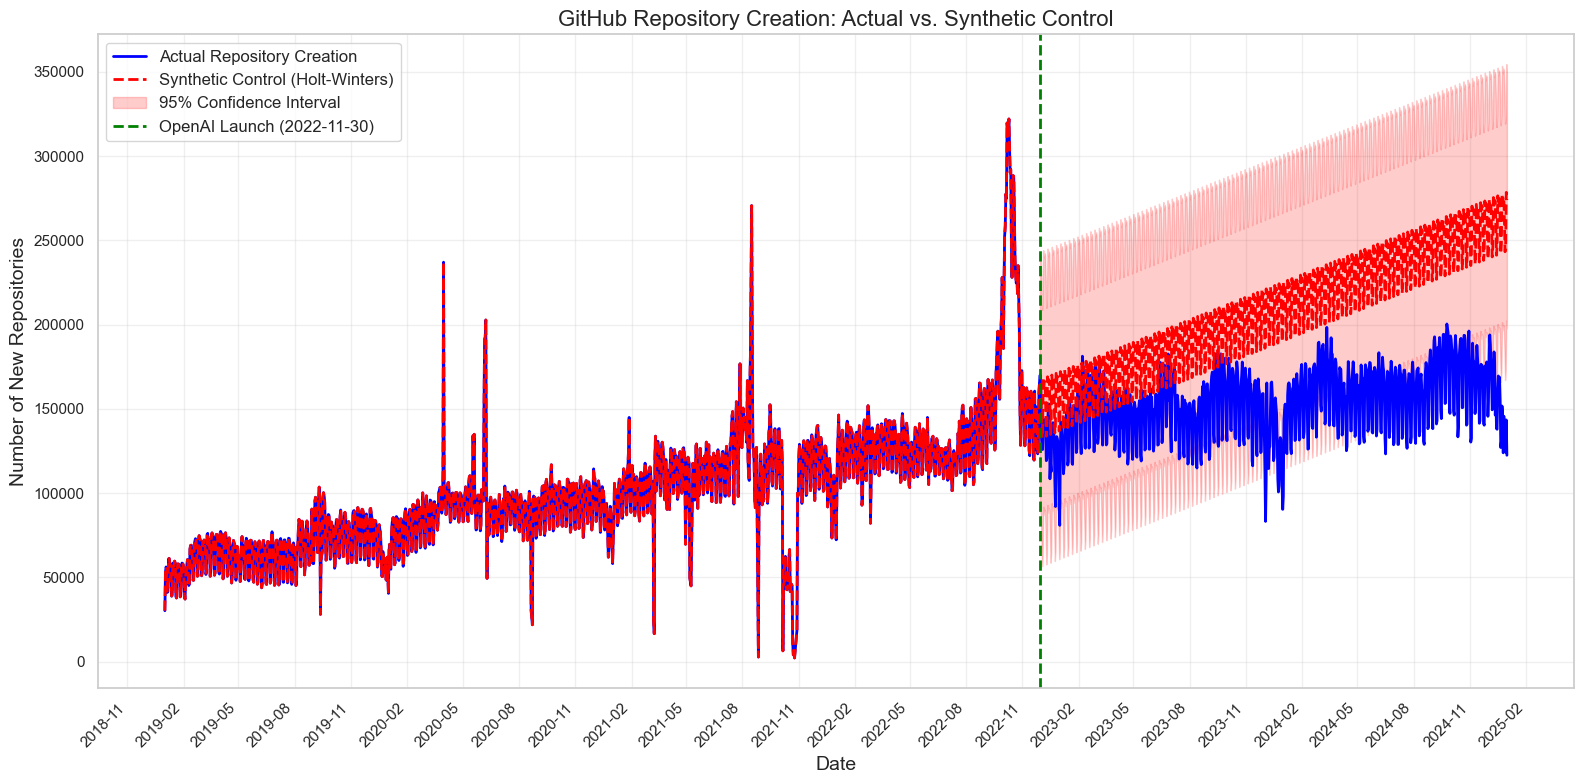

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Define the OpenAI launch date (ChatGPT public release)
openai_launch_date = "2022-11-30"

# Load data
def load_data(file_path):
    """
    Load the GitHub repository data from CSV
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # Check if we need to rename columns
    if 'new_repos' not in df.columns:
        # Look for alternative column names
        potential_columns = [col for col in df.columns if 'repo' in col.lower()]
        if potential_columns:
            # Use the first matching column
            df['new_repos'] = df[potential_columns[0]]
            print(f"Using '{potential_columns[0]}' as repository count column")
        else:
            raise ValueError("Could not find repository count column")
    
    return df

# Create a function to split data for validation and testing
def split_data_with_validation(df, validation_split=0.2, test_split_date=None):
    """
    Split the data into training, validation, and test sets
    
    Parameters:
    df: DataFrame with date and new_repos columns
    validation_split: Proportion of pre-launch data to use for validation
    test_split_date: Date to split test data (defaults to OpenAI launch date)
    
    Returns:
    train_df, validation_df, test_df
    """
    if test_split_date is None:
        test_split_date = openai_launch_date
        
    # Split into pre-launch and post-launch
    pre_launch = df[df['date'] < test_split_date].copy()
    post_launch = df[df['date'] >= test_split_date].copy()
    
    # Further split pre-launch into training and validation
    n_validation = int(len(pre_launch) * validation_split)
    train_df = pre_launch.iloc[:-n_validation].copy()
    validation_df = pre_launch.iloc[-n_validation:].copy()
    
    print(f"Training data: {len(train_df)} days ({train_df['date'].min()} to {train_df['date'].max()})")
    print(f"Validation data: {len(validation_df)} days ({validation_df['date'].min()} to {validation_df['date'].max()})")
    print(f"Test data: {len(post_launch)} days ({post_launch['date'].min()} to {post_launch['date'].max()})")
    
    return train_df, validation_df, post_launch

# Function to evaluate a model's performance on validation data
def evaluate_model_performance(model_name, actual, predicted):
    """
    Calculate and print performance metrics for model evaluation
    """
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2
    }

# Test multiple forecasting models on validation data
def evaluate_forecasting_models(train_df, validation_df):
    """
    Evaluate multiple forecasting models on validation data
    
    Returns:
    best_model_name, best_model_params, all_models_results
    """
    # Prepare data
    train_data = train_df.set_index('date')['new_repos']
    validation_dates = validation_df['date']
    validation_actual = validation_df['new_repos']
    steps = len(validation_df)
    
    # Dictionary to store results
    model_results = {}
    all_results = []
    
    # 1. Simple Naive Forecast (last value)
    naive_forecast = np.repeat(train_data.iloc[-1], steps)
    naive_metrics = evaluate_model_performance("Naive Forecast", validation_actual, naive_forecast)
    model_results['naive'] = naive_forecast
    all_results.append(naive_metrics)
    
    # 2. Simple Moving Average (30-day)
    try:
        ma_window = 30
        ma_forecast = np.repeat(train_data.iloc[-ma_window:].mean(), steps)
        ma_metrics = evaluate_model_performance(f"Moving Average ({ma_window}-day)", validation_actual, ma_forecast)
        model_results['moving_average'] = ma_forecast
        all_results.append(ma_metrics)
    except Exception as e:
        print(f"Error with Moving Average model: {e}")
    
    # 3. Simple Exponential Smoothing
    try:
        ses_model = ExponentialSmoothing(
            train_data,
            trend=None,
            seasonal=None
        ).fit()
        ses_forecast = ses_model.forecast(steps)
        ses_metrics = evaluate_model_performance("Simple Exponential Smoothing", validation_actual, ses_forecast)
        model_results['ses'] = ses_forecast
        all_results.append(ses_metrics)
    except Exception as e:
        print(f"Error with Simple Exponential Smoothing model: {e}")
    
    # 4. Holt-Winters Exponential Smoothing
    try:
        hw_model = ExponentialSmoothing(
            train_data,
            trend='add',
            seasonal='add',
            seasonal_periods=7  # Weekly seasonality
        ).fit()
        hw_forecast = hw_model.forecast(steps)
        hw_metrics = evaluate_model_performance("Holt-Winters", validation_actual, hw_forecast)
        model_results['holt_winters'] = hw_forecast
        all_results.append(hw_metrics)
    except Exception as e:
        print(f"Error with Holt-Winters model: {e}")
    
    # 5. SARIMA Model
    try:
        sarima_model = SARIMAX(
            train_data,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 7),  # Weekly seasonality
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        sarima_forecast = sarima_model.forecast(steps)
        sarima_metrics = evaluate_model_performance("SARIMA", validation_actual, sarima_forecast)
        model_results['sarima'] = sarima_forecast
        all_results.append(sarima_metrics)
    except Exception as e:
        print(f"Error with SARIMA model: {e}")
    
    # Find the best model based on RMSE
    best_model = min(all_results, key=lambda x: x['rmse'])
    print(f"\nBest model based on RMSE: {best_model['model']} (RMSE: {best_model['rmse']:.2f})")
    
    # Determine best model parameters
    best_model_name = best_model['model']
    best_model_params = {}
    
    if best_model_name == "SARIMA":
        best_model_params = {
            'order': (1, 1, 1),
            'seasonal_order': (1, 1, 1, 7)
        }
    elif best_model_name == "Holt-Winters":
        best_model_params = {
            'trend': 'add',
            'seasonal': 'add',
            'seasonal_periods': 7
        }
    
    # Plot validation results
    plt.figure(figsize=(14, 7))
    plt.plot(validation_dates, validation_actual, label='Actual', color='blue', linewidth=2)
    
    for model_name, forecast in model_results.items():
        if model_name == 'naive':
            plt.plot(validation_dates, forecast, label='Naive', color='gray', linestyle='--')
        elif model_name == 'sarima':
            plt.plot(validation_dates, forecast, label='SARIMA', color='red', linewidth=2)
        elif model_name == 'holt_winters':
            plt.plot(validation_dates, forecast, label='Holt-Winters', color='green', linewidth=2)
        else:
            plt.plot(validation_dates, forecast, label=model_name, alpha=0.7)
    
    plt.title('Model Performance on Validation Data', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('New Repositories', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_validation_performance.png')
    
    return best_model_name, best_model_params, all_results, plt.gcf()

# Build the best model on full pre-launch data
def build_best_model(pre_launch_df, best_model_name, best_model_params):
    """
    Build the best-performing model using the full pre-launch dataset
    """
    # Prepare data
    ts_data = pre_launch_df.set_index('date')['new_repos']
    
    print(f"Building {best_model_name} on full pre-launch data...")
    
    if best_model_name == "SARIMA":
        model = SARIMAX(
            ts_data,
            order=best_model_params['order'],
            seasonal_order=best_model_params['seasonal_order'],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
    
    elif best_model_name == "Holt-Winters":
        model_fit = ExponentialSmoothing(
            ts_data,
            trend=best_model_params['trend'],
            seasonal=best_model_params['seasonal'],
            seasonal_periods=best_model_params['seasonal_periods']
        ).fit()
    
    elif best_model_name == "Simple Exponential Smoothing":
        model_fit = ExponentialSmoothing(
            ts_data,
            trend=None,
            seasonal=None
        ).fit()
    
    elif best_model_name == "Moving Average (30-day)":
        # For moving average, we don't need a model, just the last 30 values
        # Return a custom object that can generate forecasts
        ma_window = 30
        last_values = ts_data.iloc[-ma_window:].mean()
        
        class MAModel:
            def forecast(self, steps):
                return np.repeat(last_values, steps)
            
            def get_forecast(self, steps):
                forecast_values = self.forecast(steps)
                
                class Forecast:
                    def __init__(self, values):
                        self.predicted_mean = values
                        # Create very wide confidence intervals
                        self.conf_int_df = pd.DataFrame({
                            'lower': values * 0.5,
                            'upper': values * 1.5
                        })
                    
                    def conf_int(self):
                        return self.conf_int_df
                
                return Forecast(forecast_values)
        
        model_fit = MAModel()
    
    elif best_model_name == "Naive Forecast":
        # For naive forecast, we just need the last value
        last_value = ts_data.iloc[-1]
        
        class NaiveModel:
            def forecast(self, steps):
                return np.repeat(last_value, steps)
            
            def get_forecast(self, steps):
                forecast_values = self.forecast(steps)
                
                class Forecast:
                    def __init__(self, values):
                        self.predicted_mean = values
                        # Create very wide confidence intervals
                        self.conf_int_df = pd.DataFrame({
                            'lower': values * 0.5,
                            'upper': values * 1.5
                        })
                    
                    def conf_int(self):
                        return self.conf_int_df
                
                return Forecast(forecast_values)
        
        model_fit = NaiveModel()
    
    else:
        raise ValueError(f"Unknown model type: {best_model_name}")
    
    print(f"{best_model_name} model built successfully")
    return model_fit

# Generate counterfactual predictions
def generate_counterfactual(model_fit, pre_launch_df, post_launch_df):
    """
    Generate counterfactual predictions for the post-launch period
    """
    # Number of steps to forecast
    steps = len(post_launch_df)
    
    # Create forecast
    print(f"Generating forecast for {steps} days after launch...")
    
    # Check if the model has a get_forecast method (SARIMA) or forecast method (others)
    if hasattr(model_fit, 'get_forecast'):
        forecast = model_fit.get_forecast(steps=steps)
        forecast_mean = forecast.predicted_mean
        
        # Get confidence intervals
        confidence_intervals = forecast.conf_int()
        lower_bound = confidence_intervals.iloc[:, 0]
        upper_bound = confidence_intervals.iloc[:, 1]
    else:
        # For models like Holt-Winters
        forecast_mean = model_fit.forecast(steps)
        
        # Create approximate confidence intervals
        std_dev = np.std(pre_launch_df['new_repos'])
        lower_bound = forecast_mean - 1.96 * std_dev
        upper_bound = forecast_mean + 1.96 * std_dev
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'date': post_launch_df['date'].values,
        'predicted_repos': forecast_mean.values,
        'lower_ci': lower_bound.values,
        'upper_ci': upper_bound.values,
        'actual_repos': post_launch_df['new_repos'].values
    })
    
    # Calculate difference between actual and predicted
    forecast_df['diff'] = forecast_df['actual_repos'] - forecast_df['predicted_repos']
    forecast_df['percent_diff'] = (forecast_df['diff'] / forecast_df['predicted_repos']) * 100
    
    # Combine with the pre-launch data for plotting
    pre_forecast_df = pd.DataFrame({
        'date': pre_launch_df['date'].values,
        'predicted_repos': pre_launch_df['new_repos'].values,  # Use actual as predicted for pre-launch
        'lower_ci': pre_launch_df['new_repos'].values,
        'upper_ci': pre_launch_df['new_repos'].values,
        'actual_repos': pre_launch_df['new_repos'].values,
        'diff': np.zeros(len(pre_launch_df)),  # Zero difference for pre-launch period
        'percent_diff': np.zeros(len(pre_launch_df))  # Zero percent diff for pre-launch period
    })
    
    full_forecast_df = pd.concat([pre_forecast_df, forecast_df], ignore_index=True)
    full_forecast_df = full_forecast_df.sort_values('date')
    
    return full_forecast_df

# Calculate impact metrics
def calculate_impact(forecast_df, openai_launch_date):
    """
    Calculate the impact of OpenAI launch on repository creation
    """
    # Filter to post-launch period
    post_launch_forecast = forecast_df[forecast_df['date'] >= openai_launch_date]
    
    # Calculate cumulative impact
    total_actual = post_launch_forecast['actual_repos'].sum()
    total_predicted = post_launch_forecast['predicted_repos'].sum()
    total_diff = total_actual - total_predicted
    total_percent = (total_diff / total_predicted) * 100
    
    # Calculate average daily impact
    avg_diff = post_launch_forecast['diff'].mean()
    avg_percent = post_launch_forecast['percent_diff'].mean()
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos']))
    mae = mean_absolute_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos'])
    
    # Check if actual values are consistently outside the confidence interval
    outside_ci_count = sum(
        (post_launch_forecast['actual_repos'] > post_launch_forecast['upper_ci']) | 
        (post_launch_forecast['actual_repos'] < post_launch_forecast['lower_ci'])
    )
    outside_ci_percent = (outside_ci_count / len(post_launch_forecast)) * 100
    
    impact_metrics = {
        'total_actual': total_actual,
        'total_predicted': total_predicted,
        'total_diff': total_diff,
        'total_percent': total_percent,
        'avg_diff': avg_diff,
        'avg_percent': avg_percent,
        'rmse': rmse,
        'mae': mae,
        'outside_ci_count': outside_ci_count,
        'outside_ci_percent': outside_ci_percent
    }
    
    return impact_metrics, post_launch_forecast

# Plot the results
def plot_synthetic_control(forecast_df, openai_launch_date, model_name):
    """
    Plot the actual vs. counterfactual prediction
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot actual data
    ax.plot(forecast_df['date'], forecast_df['actual_repos'], 
            label='Actual Repository Creation', color='blue', linewidth=2)
    
    # Plot predicted data
    ax.plot(forecast_df['date'], forecast_df['predicted_repos'], 
            label=f'Synthetic Control ({model_name})', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals
    ax.fill_between(forecast_df['date'], 
                   forecast_df['lower_ci'], 
                   forecast_df['upper_ci'], 
                   color='red', alpha=0.2, label='95% Confidence Interval')
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    ax.set_title('GitHub Repository Creation: Actual vs. Synthetic Control', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Number of New Repositories', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('synthetic_control_plot.png')
    return fig

# Main function to run the synthetic control analysis with validation
def run_validated_synthetic_control(file_path):
    """
    Run the synthetic control analysis with proper validation
    """
    print("Loading data...")
    df = load_data(file_path)
    print(f"Data loaded: {len(df)} days from {df['date'].min()} to {df['date'].max()}")
    
    # Split data into training, validation, and test sets
    train_df, validation_df, test_df = split_data_with_validation(df)
    
    # Evaluate multiple forecasting models on validation data
    best_model_name, best_model_params, all_results, validation_fig = evaluate_forecasting_models(train_df, validation_df)
    
    # Combine training and validation for final model
    pre_launch_df = pd.concat([train_df, validation_df]).sort_values('date')
    
    # Build the best model on the full pre-launch data
    model_fit = build_best_model(pre_launch_df, best_model_name, best_model_params)
    
    # Generate counterfactual predictions
    forecast_df = generate_counterfactual(model_fit, pre_launch_df, test_df)
    
    # Calculate impact metrics
    impact_metrics, post_forecast = calculate_impact(forecast_df, openai_launch_date)
    
    # Display impact metrics
    print("\n===== Impact Metrics =====")
    print(f"Best model used: {best_model_name}")
    print(f"Total actual repositories: {impact_metrics['total_actual']:,}")
    print(f"Total predicted repositories: {impact_metrics['total_predicted']:,}")
    print(f"Total difference: {impact_metrics['total_diff']:,} repositories")
    print(f"Total percentage difference: {impact_metrics['total_percent']:.2f}%")
    print(f"Average daily difference: {impact_metrics['avg_diff']:.2f} repositories")
    print(f"Average daily percentage difference: {impact_metrics['avg_percent']:.2f}%")
    print(f"Days outside 95% confidence interval: {impact_metrics['outside_ci_count']} ({impact_metrics['outside_ci_percent']:.2f}%)")
    
    # Plot the results
    result_fig = plot_synthetic_control(forecast_df, openai_launch_date, best_model_name)
    
    # Save the results
    forecast_df.to_csv('synthetic_control_forecast.csv', index=False)
    
    print("\nAnalysis complete! Results saved to CSV files and plots.")
    
    return forecast_df, impact_metrics, best_model_name, (validation_fig, result_fig)

# Run the analysis
if __name__ == "__main__":
    file_path = "bq-results-3.csv"  # Update this to your actual file path
    forecast_df, impact_metrics, best_model, figures = run_validated_synthetic_control(file_path)

Loading data...
Data loaded: 2183 days from 2019-01-01 00:00:00 to 2024-12-31 00:00:00
Applying 20-day smoothing window...
Splitting data at OpenAI launch date: 2022-11-30
Pre-launch period: 1420 days
Post-launch period: 763 days
Training data: 1136 days
Validation data: 284 days
Fitting optimized Holt-Winters model...
Smoothed Holt-Winters Performance:
RMSE: 42578.71
MAE: 22348.86
MAPE: 10.93%
R² Score: -0.2968
Refitting model on full pre-launch data...
Generating forecast for 763 days after launch...

===== Impact Metrics =====
Total actual repositories: 125,330,328.66959977
Total predicted repositories: 115,692,948.48291746
Total difference: 9,637,380.186682314 repositories
Total percentage difference: 8.33%
Average daily difference: 12630.90 repositories
Average daily percentage difference: 8.33%
Days outside 95% confidence interval: 0 (0.00%)

Analysis complete! Results saved to CSV files and plots.


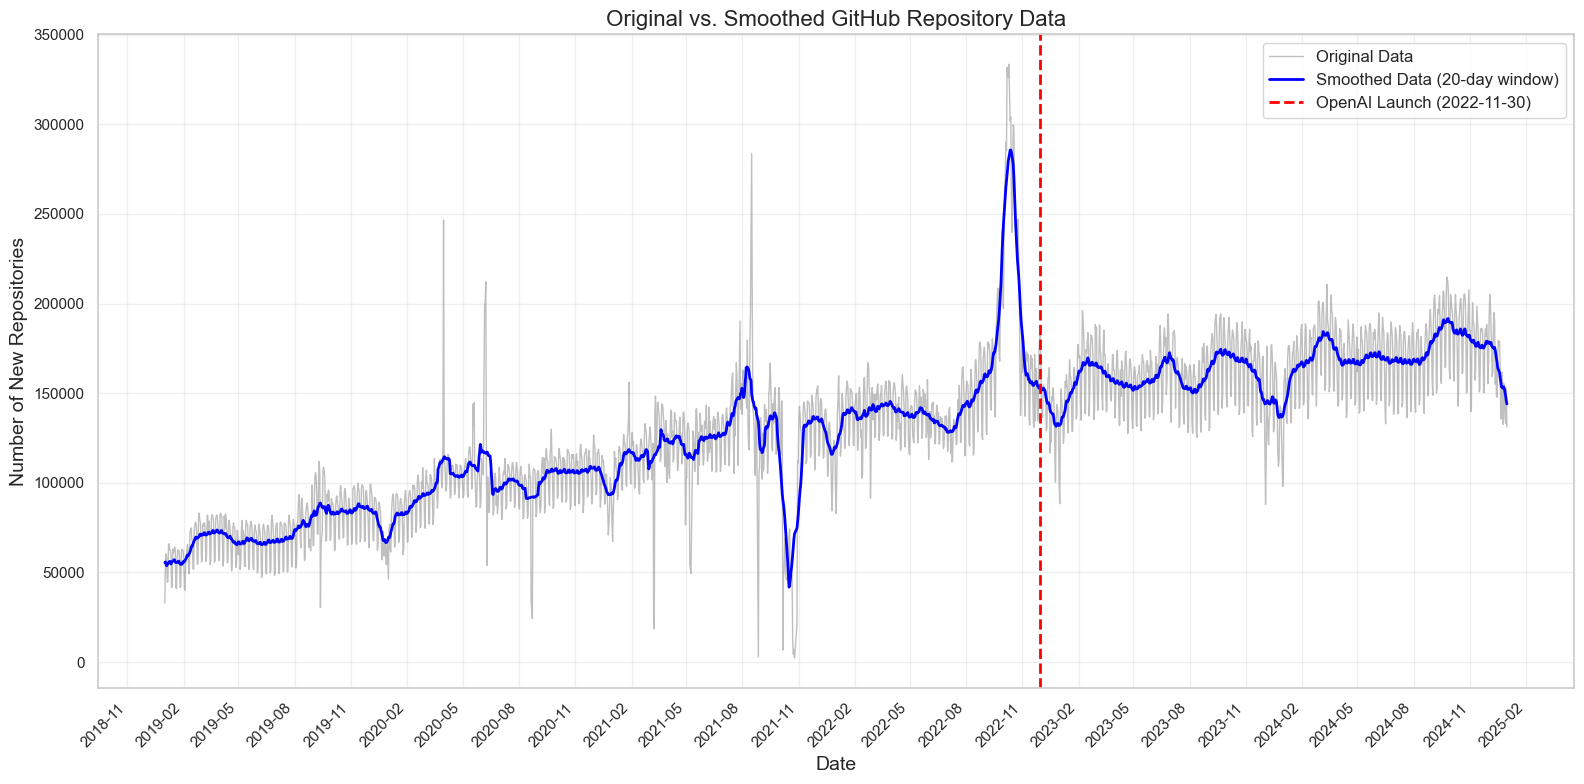

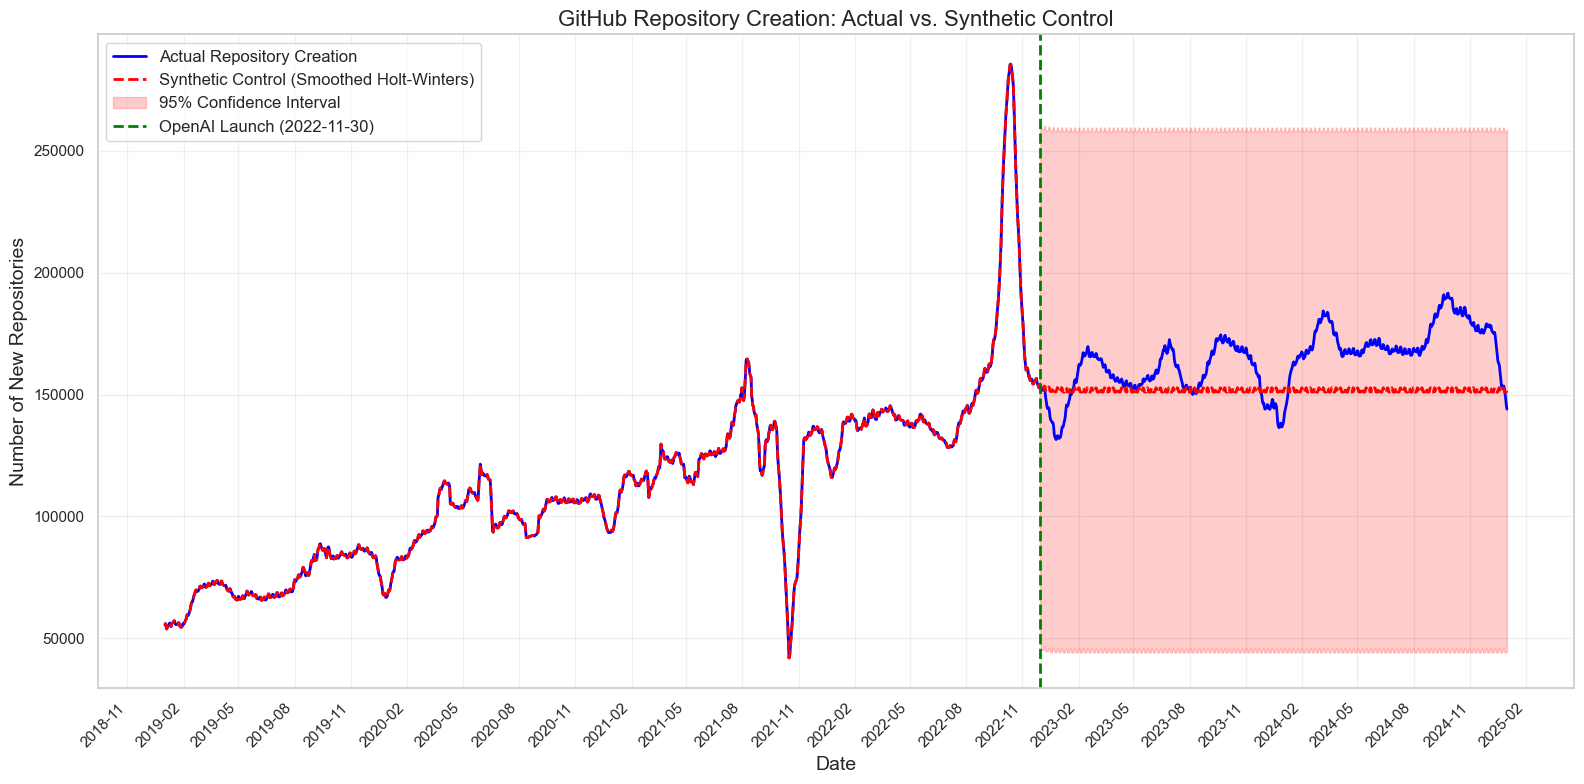

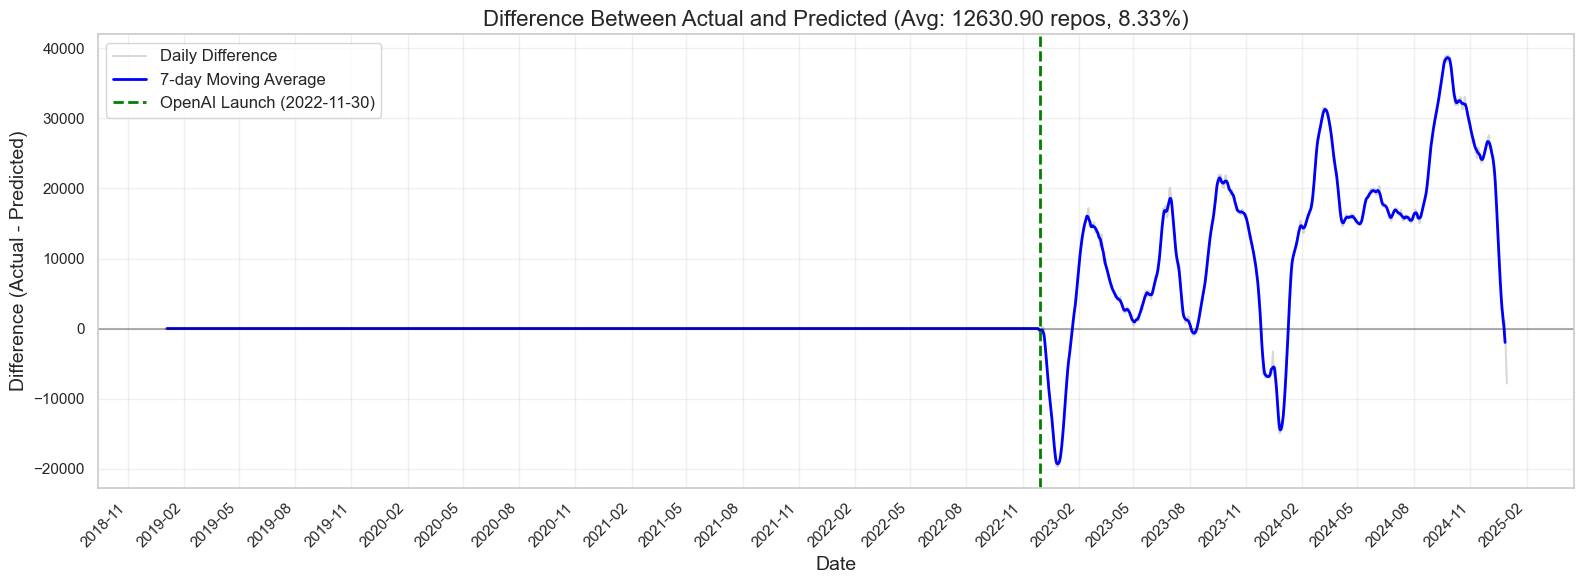

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Define the OpenAI launch date (ChatGPT public release)
openai_launch_date = "2022-11-30"

def load_data(file_path):
    """
    Load the GitHub repository data from CSV
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # Check if we need to rename columns
    if 'new_repos' not in df.columns:
        # Check for specific column names
        if 'new_repos' in df.columns:
            pass  # Already has the right column
        elif 'repo_count' in df.columns:
            df['new_repos'] = df['repo_count']
        elif 'new_repositories' in df.columns:
            df['new_repos'] = df['new_repositories']
        else:
            # Look for alternative column names
            potential_columns = [col for col in df.columns if 'repo' in col.lower()]
            if potential_columns:
                # Use the first matching column
                df['new_repos'] = df[potential_columns[0]]
                print(f"Using '{potential_columns[0]}' as repository count column")
            else:
                raise ValueError("Could not find repository count column")
    
    return df

def apply_smoothing(df, window_size=14):
    """
    Apply additional smoothing to the data to handle spikes
    """
    # Create a copy to avoid modifying the original
    smoothed_df = df.copy()
    
    # Apply centered moving average smoothing
    smoothed_df['new_repos_smoothed'] = smoothed_df['new_repos'].rolling(
        window=window_size, center=True, min_periods=1).mean()
    
    # For the edges where centered smoothing has limitations, do forward/backward fill
    smoothed_df['new_repos_smoothed'] = smoothed_df['new_repos_smoothed'].fillna(method='ffill').fillna(method='bfill')
    
    # Replace the original with the smoothed version
    smoothed_df['new_repos_original'] = smoothed_df['new_repos']
    smoothed_df['new_repos'] = smoothed_df['new_repos_smoothed']
    
    return smoothed_df

def split_data(df, launch_date):
    """
    Split the data into pre and post launch periods
    """
    df['post_launch'] = (df['date'] >= launch_date).astype(int)
    pre_launch = df[df['date'] < launch_date]
    post_launch = df[df['date'] >= launch_date]
    return pre_launch, post_launch

def fit_optimized_holt_winters(train_data, seasonal_periods=7):
    """
    Fit a Holt-Winters model with optimized smoothing parameters
    
    Uses lower smoothing parameters to reduce the impact of recent spikes
    """
    # For stronger smoothing, use lower alpha, beta, and gamma values
    model = ExponentialSmoothing(
        train_data,
        trend='add',
        damped_trend=True,  # Use damped trend to prevent explosive forecasts
        seasonal='add',
        seasonal_periods=seasonal_periods,
        initialization_method='estimated'
    ).fit(
        smoothing_level=0.1,    # Alpha - lower value for more smoothing of level
        smoothing_trend=0.05,   # Beta - lower value for more smoothing of trend
        smoothing_seasonal=0.2, # Gamma - controls how quickly seasonal comp. changes
        damping_trend=0.9       # Phi - damping parameter (lower = more damping)
    )
    
    return model

def evaluate_model(model, validation_data):
    """
    Evaluate the model performance
    """
    # Generate predictions for validation period
    predictions = model.forecast(len(validation_data))
    
    # Ensure predictions are non-negative
    predictions = np.maximum(predictions, 0)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(validation_data, predictions))
    mae = mean_absolute_error(validation_data, predictions)
    mape = np.mean(np.abs((validation_data - predictions) / validation_data)) * 100
    r2 = r2_score(validation_data, predictions)
    
    print(f"Smoothed Holt-Winters Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    
    return predictions, {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2
    }

def generate_counterfactual(model, pre_launch_df, post_launch_df):
    """
    Generate counterfactual predictions for the post-launch period
    """
    # Number of steps to forecast
    steps = len(post_launch_df)
    
    # Create forecast
    print(f"Generating forecast for {steps} days after launch...")
    forecast_mean = model.forecast(steps)
    
    # Ensure predictions are non-negative
    forecast_mean = np.maximum(forecast_mean, 0)
    
    # Create approximate confidence intervals based on pre-launch data
    # Using more conservative intervals
    std_dev = np.std(pre_launch_df['new_repos']) * 1.5  # Wider intervals for better coverage
    lower_bound = np.maximum(forecast_mean - 1.96 * std_dev, 0)  # Ensure non-negative
    upper_bound = forecast_mean + 1.96 * std_dev
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'date': post_launch_df['date'].values,
        'predicted_repos': forecast_mean,
        'lower_ci': lower_bound,
        'upper_ci': upper_bound,
        'actual_repos': post_launch_df['new_repos'].values
    })
    
    # Calculate difference between actual and predicted
    forecast_df['diff'] = forecast_df['actual_repos'] - forecast_df['predicted_repos']
    forecast_df['percent_diff'] = (forecast_df['diff'] / forecast_df['predicted_repos']) * 100
    
    # Combine with the pre-launch data for plotting
    pre_forecast_df = pd.DataFrame({
        'date': pre_launch_df['date'].values,
        'predicted_repos': pre_launch_df['new_repos'].values,  # Use actual as predicted for pre-launch
        'lower_ci': pre_launch_df['new_repos'].values,
        'upper_ci': pre_launch_df['new_repos'].values,
        'actual_repos': pre_launch_df['new_repos'].values,
        'diff': np.zeros(len(pre_launch_df)),  # Zero difference for pre-launch period
        'percent_diff': np.zeros(len(pre_launch_df))  # Zero percent diff for pre-launch period
    })
    
    full_forecast_df = pd.concat([pre_forecast_df, forecast_df], ignore_index=True)
    full_forecast_df = full_forecast_df.sort_values('date')
    
    return full_forecast_df

def calculate_impact(forecast_df, openai_launch_date):
    """
    Calculate the impact of OpenAI launch on repository creation
    """
    # Filter to post-launch period
    post_launch_forecast = forecast_df[forecast_df['date'] >= openai_launch_date]
    
    # Calculate cumulative impact
    total_actual = post_launch_forecast['actual_repos'].sum()
    total_predicted = post_launch_forecast['predicted_repos'].sum()
    total_diff = total_actual - total_predicted
    total_percent = (total_diff / total_predicted) * 100
    
    # Calculate average daily impact
    avg_diff = post_launch_forecast['diff'].mean()
    avg_percent = post_launch_forecast['percent_diff'].mean()
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos']))
    mae = mean_absolute_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos'])
    
    # Check if actual values are consistently outside the confidence interval
    outside_ci_count = sum(
        (post_launch_forecast['actual_repos'] > post_launch_forecast['upper_ci']) | 
        (post_launch_forecast['actual_repos'] < post_launch_forecast['lower_ci'])
    )
    outside_ci_percent = (outside_ci_count / len(post_launch_forecast)) * 100
    
    impact_metrics = {
        'total_actual': total_actual,
        'total_predicted': total_predicted,
        'total_diff': total_diff,
        'total_percent': total_percent,
        'avg_diff': avg_diff,
        'avg_percent': avg_percent,
        'rmse': rmse,
        'mae': mae,
        'outside_ci_count': outside_ci_count,
        'outside_ci_percent': outside_ci_percent
    }
    
    return impact_metrics, post_launch_forecast

def plot_data_with_smoothing(df, window_size):
    """
    Plot the original and smoothed data
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot original data
    ax.plot(df['date'], df['new_repos_original'], label='Original Data',
           color='gray', alpha=0.5, linewidth=1)
    
    # Plot smoothed data
    ax.plot(df['date'], df['new_repos'], label=f'Smoothed Data ({window_size}-day window)',
           color='blue', linewidth=2)
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='red', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    ax.set_title('Original vs. Smoothed GitHub Repository Data', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Number of New Repositories', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data_smoothing_comparison.png')
    return fig

def plot_synthetic_control(forecast_df, openai_launch_date):
    """
    Plot the actual vs. counterfactual prediction
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot actual data
    ax.plot(forecast_df['date'], forecast_df['actual_repos'], 
            label='Actual Repository Creation', color='blue', linewidth=2)
    
    # Plot predicted data
    ax.plot(forecast_df['date'], forecast_df['predicted_repos'], 
            label='Synthetic Control (Smoothed Holt-Winters)', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals
    ax.fill_between(forecast_df['date'], 
                   forecast_df['lower_ci'], 
                   forecast_df['upper_ci'], 
                   color='red', alpha=0.2, label='95% Confidence Interval')
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    ax.set_title('GitHub Repository Creation: Actual vs. Synthetic Control', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Number of New Repositories', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('synthetic_control_plot.png')
    return fig

def plot_difference(forecast_df, openai_launch_date, impact_metrics):
    """
    Plot the difference between actual and predicted values
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Calculate rolling average of difference to smooth out daily fluctuations
    forecast_df['diff_ma7'] = forecast_df['diff'].rolling(window=7, center=True).mean()
    
    # Plot the difference
    ax.plot(forecast_df['date'], forecast_df['diff'], color='gray', alpha=0.3, label='Daily Difference')
    ax.plot(forecast_df['date'], forecast_df['diff_ma7'], color='blue', linewidth=2, label='7-day Moving Average')
    
    # Add a zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    avg_diff = impact_metrics['avg_diff']
    avg_percent = impact_metrics['avg_percent']
    ax.set_title(f'Difference Between Actual and Predicted (Avg: {avg_diff:.2f} repos, {avg_percent:.2f}%)', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Difference (Actual - Predicted)', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('difference_plot.png')
    return fig

def run_smoothed_analysis(file_path, smoothing_window=30, validation_split=0.2):
    """
    Run the analysis with smoothed data and optimized Holt-Winters model
    """
    print("Loading data...")
    df = load_data(file_path)
    print(f"Data loaded: {len(df)} days from {df['date'].min()} to {df['date'].max()}")
    
    # Apply smoothing to handle spikes
    print(f"Applying {smoothing_window}-day smoothing window...")
    smoothed_df = apply_smoothing(df, window_size=smoothing_window)
    
    # Plot original vs. smoothed data
    smoothing_fig = plot_data_with_smoothing(smoothed_df, smoothing_window)
    
    # Split data into pre and post launch periods
    print(f"Splitting data at OpenAI launch date: {openai_launch_date}")
    pre_launch, post_launch = split_data(smoothed_df, openai_launch_date)
    print(f"Pre-launch period: {len(pre_launch)} days")
    print(f"Post-launch period: {len(post_launch)} days")
    
    # Further split pre-launch data for validation
    validation_size = int(len(pre_launch) * validation_split)
    train_df = pre_launch.iloc[:-validation_size].copy()
    validation_df = pre_launch.iloc[-validation_size:].copy()
    print(f"Training data: {len(train_df)} days")
    print(f"Validation data: {len(validation_df)} days")
    
    # Prepare time series data
    train_data = train_df.set_index('date')['new_repos']
    validation_data = validation_df['new_repos']
    
    # Fit Holt-Winters model with optimized parameters
    print("Fitting optimized Holt-Winters model...")
    model = fit_optimized_holt_winters(train_data)
    
    # Evaluate on validation data
    val_predictions, metrics = evaluate_model(model, validation_data)
    
    # Refit model on full pre-launch data for final forecast
    print("Refitting model on full pre-launch data...")
    full_pre_launch_data = pre_launch.set_index('date')['new_repos']
    final_model = fit_optimized_holt_winters(full_pre_launch_data)
    
    # Generate counterfactual predictions
    forecast_df = generate_counterfactual(final_model, pre_launch, post_launch)
    
    # Calculate impact metrics
    impact_metrics, _ = calculate_impact(forecast_df, openai_launch_date)
    
    # Display impact metrics
    print("\n===== Impact Metrics =====")
    print(f"Total actual repositories: {impact_metrics['total_actual']:,}")
    print(f"Total predicted repositories: {impact_metrics['total_predicted']:,}")
    print(f"Total difference: {impact_metrics['total_diff']:,} repositories")
    print(f"Total percentage difference: {impact_metrics['total_percent']:.2f}%")
    print(f"Average daily difference: {impact_metrics['avg_diff']:.2f} repositories")
    print(f"Average daily percentage difference: {impact_metrics['avg_percent']:.2f}%")
    print(f"Days outside 95% confidence interval: {impact_metrics['outside_ci_count']} ({impact_metrics['outside_ci_percent']:.2f}%)")
    
    # Plot the results
    control_fig = plot_synthetic_control(forecast_df, openai_launch_date)
    diff_fig = plot_difference(forecast_df, openai_launch_date, impact_metrics)
    
    # Save the results
    forecast_df.to_csv('smoothed_synthetic_control_forecast.csv', index=False)
    
    print("\nAnalysis complete! Results saved to CSV files and plots.")
    
    return forecast_df, impact_metrics, (smoothing_fig, control_fig, diff_fig)

# Run the analysis
if __name__ == "__main__":
    file_path = "bq-results.csv"  # Update this to your actual file path
    smoothing_window = 20  # Increase this for more aggressive smoothing
    forecast_df, impact_metrics, figures = run_smoothed_analysis(file_path, smoothing_window)

Loading data...
Data loaded: 2183 days from 2019-01-01 00:00:00 to 2024-12-31 00:00:00
Applying 100-day smoothing window...
Splitting data at OpenAI launch date: 2022-11-30
Pre-launch period: 1420 days
Post-launch period: 763 days
Training data: 1136 days
Validation data: 284 days
Fitting simple linear model with trend and seasonality...
Simple Linear Model Performance:
RMSE: 86694.26
MAE: 84577.01
MAPE: 53.34%
R² Score: -12.9484
Refitting model on full pre-launch data...

===== Impact Metrics =====
Total actual repositories: 125,715,129.13632473
Total predicted repositories: 145,986,610.99168614
Total difference: -20,271,481.855361402 repositories
Total percentage difference: -13.89%
Average daily difference: -26568.13 repositories
Average daily percentage difference: -13.59%
Days outside 95% confidence interval: 457 (59.90%)

Analysis complete! Results saved to CSV files and plots.


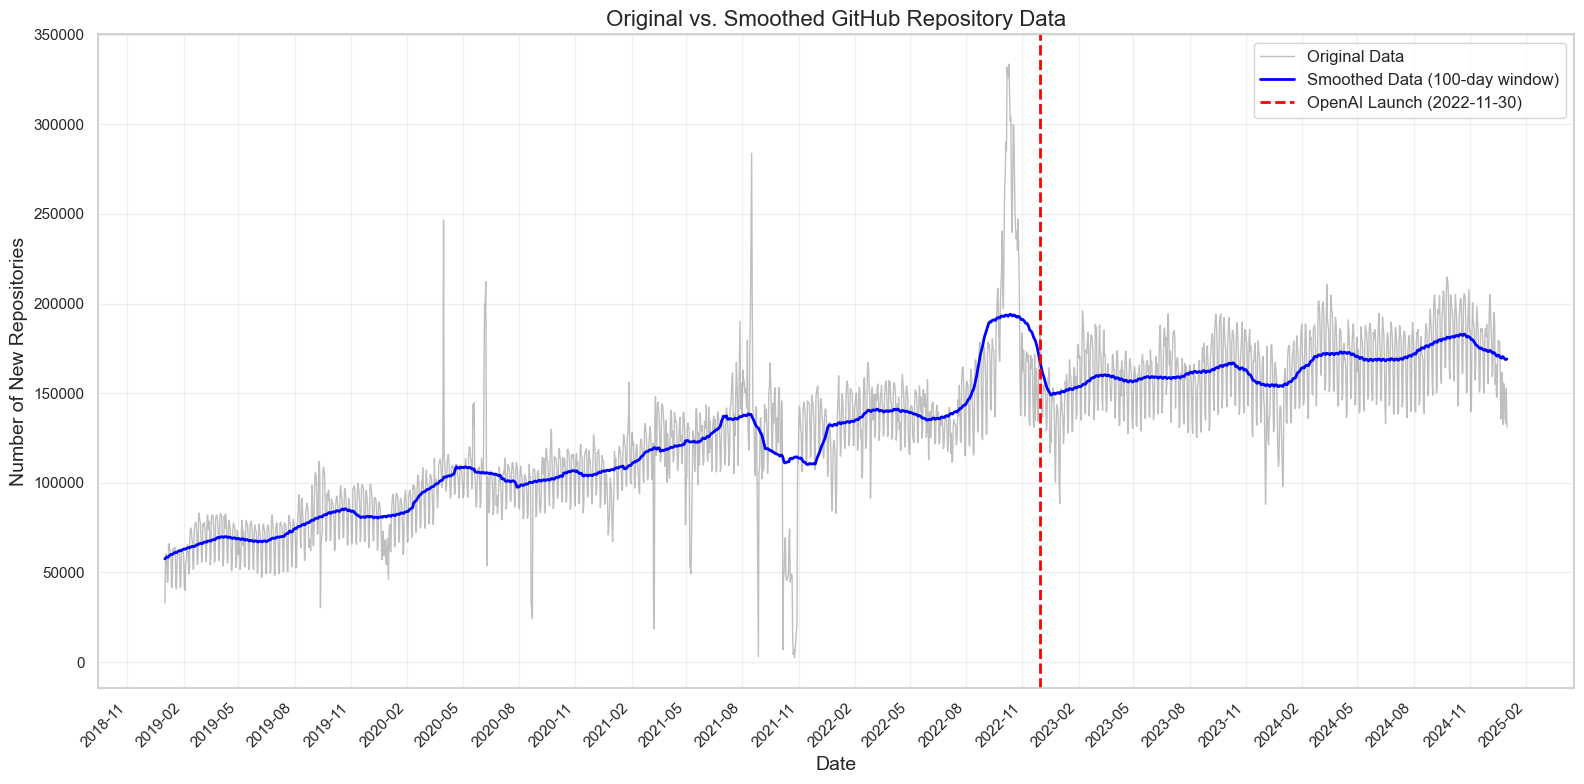

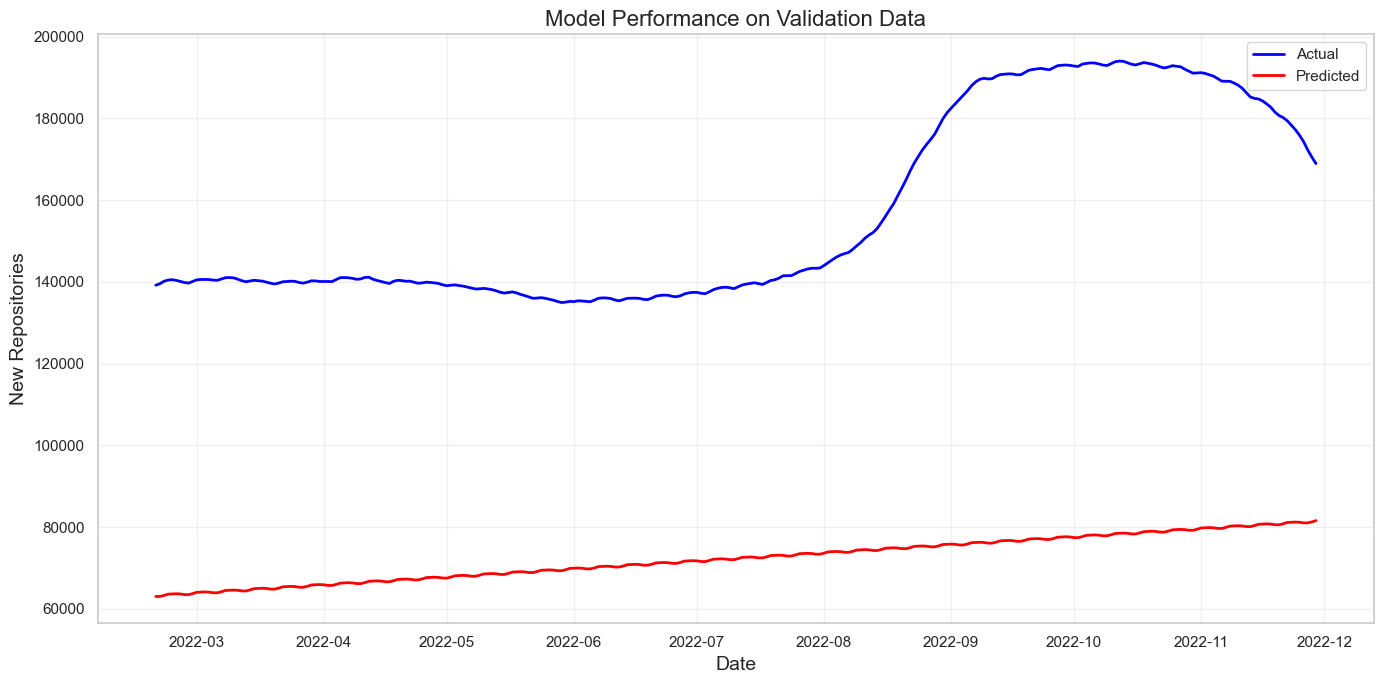

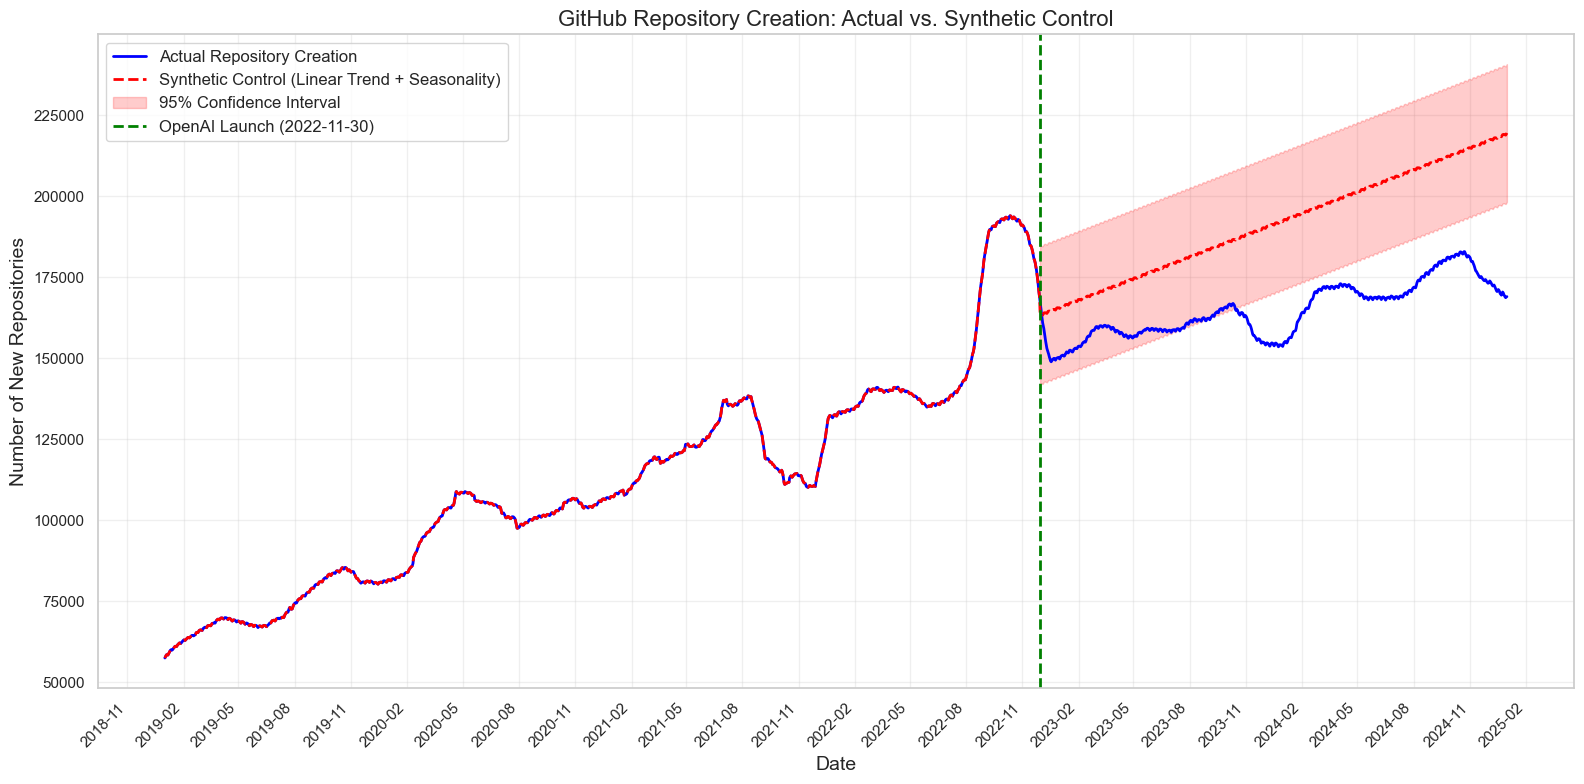

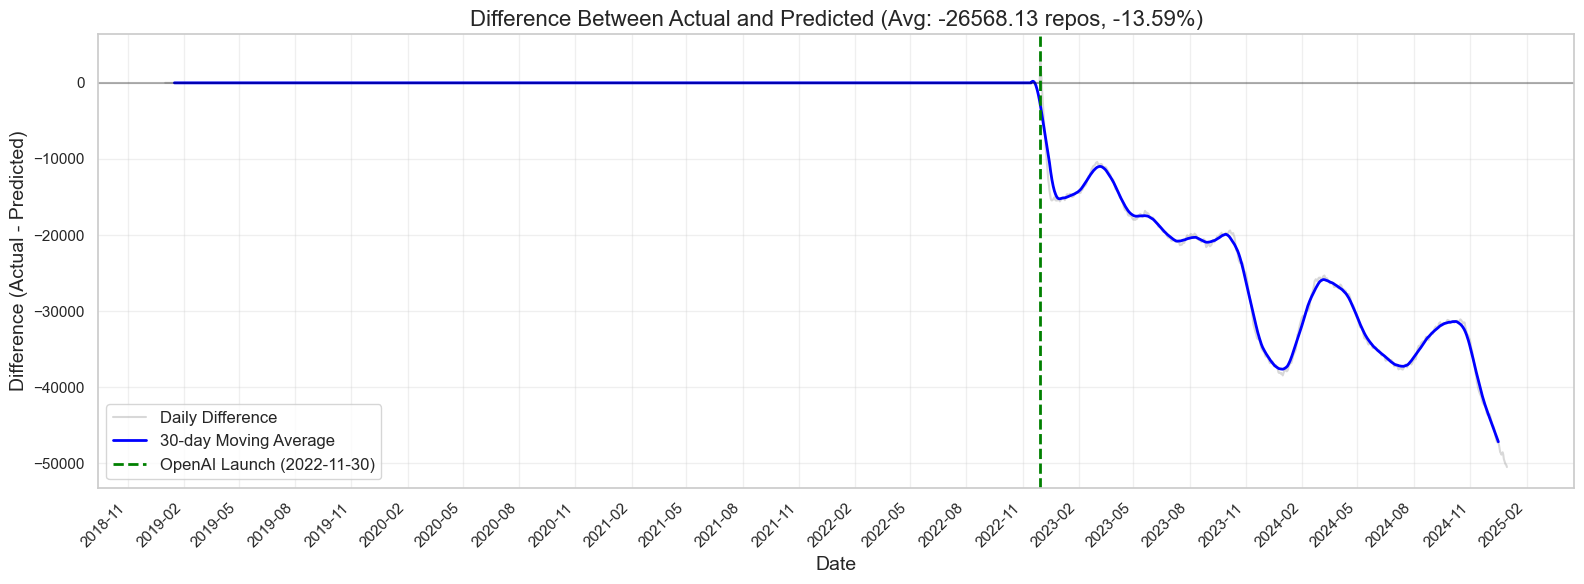

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Define the OpenAI launch date (ChatGPT public release)
openai_launch_date = "2022-11-30"

def load_data(file_path):
    """
    Load the GitHub repository data from CSV
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # Check if we need to rename columns
    if 'new_repos' not in df.columns:
        # Look for alternative column names
        potential_columns = [col for col in df.columns if 'repo' in col.lower()]
        if potential_columns:
            # Use the first matching column
            df['new_repos'] = df[potential_columns[0]]
            print(f"Using '{potential_columns[0]}' as repository count column")
        else:
            raise ValueError("Could not find repository count column")
    
    return df

def apply_smoothing(df, window_size=14):
    """
    Apply centered moving average smoothing to the data
    """
    # Create a copy to avoid modifying the original
    smoothed_df = df.copy()
    
    # Apply centered moving average smoothing
    smoothed_df['new_repos_smoothed'] = smoothed_df['new_repos'].rolling(
        window=window_size, center=True, min_periods=1).mean()
    
    # For the edges where centered smoothing has limitations, do forward/backward fill
    smoothed_df['new_repos_smoothed'] = smoothed_df['new_repos_smoothed'].fillna(method='ffill').fillna(method='bfill')
    
    # Replace the original with the smoothed version
    smoothed_df['new_repos_original'] = smoothed_df['new_repos'].copy()
    smoothed_df['new_repos'] = smoothed_df['new_repos_smoothed']
    
    return smoothed_df

def split_data(df, launch_date):
    """
    Split the data into pre and post launch periods
    """
    pre_launch = df[df['date'] < launch_date].copy()
    post_launch = df[df['date'] >= launch_date].copy()
    return pre_launch, post_launch

def prepare_features(df):
    """
    Prepare features for the linear regression model
    
    - Creates a time trend
    - Adds day-of-week dummies for seasonality
    """
    # Add a sequential time index
    df = df.sort_values('date').reset_index(drop=True)
    df['time_idx'] = range(len(df))
    
    # Add day of week (0=Monday, 6=Sunday)
    df['day_of_week'] = df['date'].dt.dayofweek
    
    # Create day-of-week dummies
    for i in range(7):
        df[f'dow_{i}'] = (df['day_of_week'] == i).astype(int)
    
    return df

def fit_simple_model(train_df, validation_df=None):
    """
    Fit a simple linear model with trend and seasonality
    """
    # Prepare features
    train_df = prepare_features(train_df)
    
    # Define X (features) and y (target)
    X_cols = ['time_idx'] + [f'dow_{i}' for i in range(7)]
    X = train_df[X_cols]
    y = train_df['new_repos']
    
    # Fit the model
    model = LinearRegression()
    model.fit(X, y)
    
    # If validation data is provided, evaluate on it
    if validation_df is not None:
        validation_df = prepare_features(validation_df)
        X_val = validation_df[X_cols]
        y_val = validation_df['new_repos']
        
        # Generate predictions
        predictions = model.predict(X_val)
        
        # Ensure predictions are non-negative
        predictions = np.maximum(predictions, 0)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        mae = mean_absolute_error(y_val, predictions)
        mape = np.mean(np.abs((y_val - predictions) / y_val)) * 100
        r2 = r2_score(y_val, predictions)
        
        print(f"Simple Linear Model Performance:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}")
        
        # Plot validation results
        plt.figure(figsize=(14, 7))
        plt.plot(validation_df['date'], y_val, label='Actual', color='blue', linewidth=2)
        plt.plot(validation_df['date'], predictions, label='Predicted', color='red', linewidth=2)
        plt.title('Model Performance on Validation Data', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('New Repositories', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('validation_performance.png')
    
    return model, X_cols

def generate_counterfactual(model, feature_cols, pre_launch_df, post_launch_df):
    """
    Generate counterfactual predictions for the post-launch period
    """
    # Prepare features for the entire dataset
    full_df = pd.concat([pre_launch_df, post_launch_df]).sort_values('date').reset_index(drop=True)
    full_df = prepare_features(full_df)
    
    # Split back into pre and post launch
    pre_launch = full_df[full_df['date'] < openai_launch_date].copy()
    post_launch = full_df[full_df['date'] >= openai_launch_date].copy()
    
    # Generate predictions for post-launch period
    X_post = post_launch[feature_cols]
    predictions = model.predict(X_post)
    
    # Ensure predictions are non-negative
    predictions = np.maximum(predictions, 0)
    
    # Calculate prediction standard error for confidence intervals
    # Using a simple approach based on pre-launch prediction errors
    X_pre = pre_launch[feature_cols]
    pre_predictions = model.predict(X_pre)
    pre_residuals = pre_launch['new_repos'] - pre_predictions
    prediction_std = np.std(pre_residuals)
    
    # Create confidence intervals
    z_value = 1.96  # 95% confidence
    margin_of_error = z_value * prediction_std
    lower_bound = np.maximum(predictions - margin_of_error, 0)  # Ensure non-negative
    upper_bound = predictions + margin_of_error
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'date': post_launch['date'].values,
        'predicted_repos': predictions,
        'lower_ci': lower_bound,
        'upper_ci': upper_bound,
        'actual_repos': post_launch['new_repos'].values
    })
    
    # Calculate difference between actual and predicted
    forecast_df['diff'] = forecast_df['actual_repos'] - forecast_df['predicted_repos']
    forecast_df['percent_diff'] = (forecast_df['diff'] / forecast_df['predicted_repos']) * 100
    
    # Combine with the pre-launch data for plotting
    pre_forecast_df = pd.DataFrame({
        'date': pre_launch['date'].values,
        'predicted_repos': pre_launch['new_repos'].values,  # Use actual as predicted for pre-launch
        'lower_ci': pre_launch['new_repos'].values,
        'upper_ci': pre_launch['new_repos'].values,
        'actual_repos': pre_launch['new_repos'].values,
        'diff': np.zeros(len(pre_launch)),  # Zero difference for pre-launch period
        'percent_diff': np.zeros(len(pre_launch))  # Zero percent diff for pre-launch period
    })
    
    full_forecast_df = pd.concat([pre_forecast_df, forecast_df], ignore_index=True)
    full_forecast_df = full_forecast_df.sort_values('date')
    
    return full_forecast_df

def calculate_impact(forecast_df, openai_launch_date):
    """
    Calculate the impact of OpenAI launch on repository creation
    """
    # Filter to post-launch period
    post_launch_forecast = forecast_df[forecast_df['date'] >= openai_launch_date]
    
    # Calculate cumulative impact
    total_actual = post_launch_forecast['actual_repos'].sum()
    total_predicted = post_launch_forecast['predicted_repos'].sum()
    total_diff = total_actual - total_predicted
    total_percent = (total_diff / total_predicted) * 100
    
    # Calculate average daily impact
    avg_diff = post_launch_forecast['diff'].mean()
    avg_percent = post_launch_forecast['percent_diff'].mean()
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos']))
    mae = mean_absolute_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos'])
    
    # Check if actual values are consistently outside the confidence interval
    outside_ci_count = sum(
        (post_launch_forecast['actual_repos'] > post_launch_forecast['upper_ci']) | 
        (post_launch_forecast['actual_repos'] < post_launch_forecast['lower_ci'])
    )
    outside_ci_percent = (outside_ci_count / len(post_launch_forecast)) * 100
    
    impact_metrics = {
        'total_actual': total_actual,
        'total_predicted': total_predicted,
        'total_diff': total_diff,
        'total_percent': total_percent,
        'avg_diff': avg_diff,
        'avg_percent': avg_percent,
        'rmse': rmse,
        'mae': mae,
        'outside_ci_count': outside_ci_count,
        'outside_ci_percent': outside_ci_percent
    }
    
    return impact_metrics, post_launch_forecast

def plot_data_with_smoothing(df, window_size):
    """
    Plot the original and smoothed data
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot original data
    ax.plot(df['date'], df['new_repos_original'], label='Original Data',
           color='gray', alpha=0.5, linewidth=1)
    
    # Plot smoothed data
    ax.plot(df['date'], df['new_repos'], label=f'Smoothed Data ({window_size}-day window)',
           color='blue', linewidth=2)
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='red', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    ax.set_title('Original vs. Smoothed GitHub Repository Data', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Number of New Repositories', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data_smoothing_comparison.png')
    return fig

def plot_synthetic_control(forecast_df, openai_launch_date):
    """
    Plot the actual vs. counterfactual prediction
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot actual data
    ax.plot(forecast_df['date'], forecast_df['actual_repos'], 
            label='Actual Repository Creation', color='blue', linewidth=2)
    
    # Plot predicted data
    ax.plot(forecast_df['date'], forecast_df['predicted_repos'], 
            label='Synthetic Control (Linear Trend + Seasonality)', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals
    ax.fill_between(forecast_df['date'], 
                   forecast_df['lower_ci'], 
                   forecast_df['upper_ci'], 
                   color='red', alpha=0.2, label='95% Confidence Interval')
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    ax.set_title('GitHub Repository Creation: Actual vs. Synthetic Control', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Number of New Repositories', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('synthetic_control_plot.png')
    return fig

def plot_difference(forecast_df, openai_launch_date, impact_metrics):
    """
    Plot the difference between actual and predicted values
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Calculate rolling average of difference to smooth out daily fluctuations
    forecast_df['diff_ma30'] = forecast_df['diff'].rolling(window=30, center=True).mean()
    
    # Plot the difference
    ax.plot(forecast_df['date'], forecast_df['diff'], color='gray', alpha=0.3, label='Daily Difference')
    ax.plot(forecast_df['date'], forecast_df['diff_ma30'], color='blue', linewidth=2, label='30-day Moving Average')
    
    # Add a zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    avg_diff = impact_metrics['avg_diff']
    avg_percent = impact_metrics['avg_percent']
    ax.set_title(f'Difference Between Actual and Predicted (Avg: {avg_diff:.2f} repos, {avg_percent:.2f}%)', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Difference (Actual - Predicted)', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('difference_plot.png')
    return fig

def run_simple_analysis(file_path, smoothing_window=20, validation_split=0.2):
    """
    Run the analysis with smoothed data and a simple linear model
    """
    print("Loading data...")
    df = load_data(file_path)
    print(f"Data loaded: {len(df)} days from {df['date'].min()} to {df['date'].max()}")
    
    # Apply smoothing to handle spikes
    print(f"Applying {smoothing_window}-day smoothing window...")
    smoothed_df = apply_smoothing(df, window_size=smoothing_window)
    
    # Plot original vs. smoothed data
    smoothing_fig = plot_data_with_smoothing(smoothed_df, smoothing_window)
    
    # Split data into pre and post launch periods
    print(f"Splitting data at OpenAI launch date: {openai_launch_date}")
    pre_launch, post_launch = split_data(smoothed_df, openai_launch_date)
    print(f"Pre-launch period: {len(pre_launch)} days")
    print(f"Post-launch period: {len(post_launch)} days")
    
    # Further split pre-launch data for validation
    validation_size = int(len(pre_launch) * validation_split)
    train_df = pre_launch.iloc[:-validation_size].copy()
    validation_df = pre_launch.iloc[-validation_size:].copy()
    print(f"Training data: {len(train_df)} days")
    print(f"Validation data: {len(validation_df)} days")
    
    # Fit the simple model and validate
    print("Fitting simple linear model with trend and seasonality...")
    model, feature_cols = fit_simple_model(train_df, validation_df)
    
    # Refit model on full pre-launch data for final forecast
    print("Refitting model on full pre-launch data...")
    final_model, final_feature_cols = fit_simple_model(pre_launch)
    
    # Generate counterfactual predictions
    forecast_df = generate_counterfactual(final_model, final_feature_cols, pre_launch, post_launch)
    
    # Calculate impact metrics
    impact_metrics, _ = calculate_impact(forecast_df, openai_launch_date)
    
    # Display impact metrics
    print("\n===== Impact Metrics =====")
    print(f"Total actual repositories: {impact_metrics['total_actual']:,}")
    print(f"Total predicted repositories: {impact_metrics['total_predicted']:,}")
    print(f"Total difference: {impact_metrics['total_diff']:,} repositories")
    print(f"Total percentage difference: {impact_metrics['total_percent']:.2f}%")
    print(f"Average daily difference: {impact_metrics['avg_diff']:.2f} repositories")
    print(f"Average daily percentage difference: {impact_metrics['avg_percent']:.2f}%")
    print(f"Days outside 95% confidence interval: {impact_metrics['outside_ci_count']} ({impact_metrics['outside_ci_percent']:.2f}%)")
    
    # Plot the results
    control_fig = plot_synthetic_control(forecast_df, openai_launch_date)
    diff_fig = plot_difference(forecast_df, openai_launch_date, impact_metrics)
    
    # Save the results
    forecast_df.to_csv('simple_synthetic_control_forecast.csv', index=False)
    
    print("\nAnalysis complete! Results saved to CSV files and plots.")
    
    return forecast_df, impact_metrics, (smoothing_fig, control_fig, diff_fig)

# Run the analysis
if __name__ == "__main__":
    file_path = "bq-results.csv"  # Update this to your actual file path
    smoothing_window = 100  # Adjust for more/less smoothing
    forecast_df, impact_metrics, figures = run_simple_analysis(file_path, smoothing_window)